# Library

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.optim as optim
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import CoraFull
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
import collections
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [ ]:
# Load CoraFull dataset
dataset_CoraFull = CoraFull(root='./data')
data_CoraFull = dataset_CoraFull[0]

# Split data to 70% Train, 10% Validation, 20% Test
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph_CoraFull = split(data_CoraFull)

In [ ]:
# Load CiteSeer Dataset
dataset_Cite = Planetoid(root='./data', name='CiteSeer')
data_Cite = dataset_Cite[0]

# Split data to 70% Train, 10% Validation, 20% Test
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph_Cite = split(data_Cite)

In [ ]:
def train(model, optimizer, graph):
    model.train()
    optimizer.zero_grad()
    out = model(graph.x.to(device), graph.edge_index.to(device))
    loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, graph):
    model.eval()
    with torch.no_grad():
        out = model(graph.x.to(device), graph.edge_index.to(device))
        pred = out.argmax(dim=1)
        acc = pred[graph.test_mask].eq(graph.y[graph.test_mask]).sum().item() / graph.test_mask.sum().item()
    return acc

In [ ]:
def plotBestLayers(dataset, epochs, num_layers, lr, weight_decay, hidden_channel, dropout_rate,
                   train_losses_gcn, train_losses_dropedge,
                   val_losses_gcn, val_losses_dropedge,
                   test_accs_gcn, test_accs_dropedge):

    plt.figure(figsize=(30, 7)).suptitle(f'{dataset} - ({num_layers}-Layer & {hidden_channel}-Hidden channel & {lr}-LR, {weight_decay}-Weight decay & {dropout_rate}-Dropout rate)\n')
    # Training Loss
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_losses_gcn, label=f'GCN')
    plt.plot(range(1, epochs + 1), train_losses_dropedge, label=f'DropEdge GCN')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title(f'Training Loss Comparison')
    plt.legend()
    min_loss_epoch_gcn = train_losses_gcn.index(min(train_losses_gcn)) + 1
    min_loss_epoch_dropedge = train_losses_dropedge.index(min(train_losses_dropedge)) + 1
    plt.annotate(f'Min Loss GCN: {min(train_losses_gcn):.4f}', xy=(min_loss_epoch_gcn, min(train_losses_gcn)),
                 xytext=(min_loss_epoch_gcn + 10, min(train_losses_gcn) + 0.1), arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.annotate(f'Min Loss DropEdge GCN: {min(train_losses_dropedge):.4f}', xy=(min_loss_epoch_dropedge, min(train_losses_dropedge)),
                 xytext=(min_loss_epoch_dropedge + 10, min(train_losses_dropedge) + 0.2), arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Validation Loss
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), val_losses_gcn, label=f'GCN')
    plt.plot(range(1, epochs + 1), val_losses_dropedge, label=f'DropEdge GCN')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss Comparison')
    plt.legend()
    min_val_loss_epoch_gcn = val_losses_gcn.index(min(val_losses_gcn)) + 1
    min_val_loss_epoch_dropedge = val_losses_dropedge.index(min(val_losses_dropedge)) + 1
    plt.annotate(f'Min Val Loss GCN: {min(val_losses_gcn):.4f}', xy=(min_val_loss_epoch_gcn, min(val_losses_gcn)),
                 xytext=(min_val_loss_epoch_gcn + 10, min(val_losses_gcn) + 0.4), arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.annotate(f'Min Val Loss DropEdge GCN: {min(val_losses_dropedge):.4f}', xy=(min_val_loss_epoch_dropedge, min(val_losses_dropedge)),
                 xytext=(min_val_loss_epoch_dropedge + 10, min(val_losses_dropedge) + 0.6), arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Test Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), test_accs_gcn, label=f'GCN')
    plt.plot(range(1, epochs + 1), test_accs_dropedge, label=f'DropEdge GCN')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title(f'Test Accuracy Comparison')
    plt.legend()
    max_test_acc_epoch_gcn = test_accs_gcn.index(max(test_accs_gcn)) + 1
    max_test_acc_epoch_dropedge = test_accs_dropedge.index(max(test_accs_dropedge)) + 1
    plt.annotate(f'Max Test Acc GCN: {max(test_accs_gcn):.4f}', xy=(max_test_acc_epoch_gcn, max(test_accs_gcn)),
                 xytext=(max_test_acc_epoch_gcn + 10, max(test_accs_gcn) - 0.2), arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.annotate(f'Max Test Acc DropEdge GCN: {max(test_accs_dropedge):.4f}', xy=(max_test_acc_epoch_dropedge, max(test_accs_dropedge)),
                 xytext=(max_test_acc_epoch_dropedge + 10, max(test_accs_dropedge) - 0.3), arrowprops=dict(facecolor='black', arrowstyle='->'))

    plt.tight_layout()
    plt.show()

    print(f'\nTest Accuracy of GCN: {np.mean(test_accs_gcn)}')
    print(f'Test Accuracy of DropEdge: {np.mean(test_accs_dropedge)}')

In [ ]:
def plotBestLayers2(dataset, epochs, num_layers, lr, weight_decay, hidden_channel, dropout_rate,
                   train_losses_gcn, train_losses_dropedge, train_losses_skipconn,
                   val_losses_gcn, val_losses_dropedge, val_losses_skipconn,
                   test_accs_gcn, test_accs_dropedge, test_accs_skipconn):

    plt.figure(figsize=(30, 7)).suptitle(f'{dataset} - ({num_layers}-Layer & {hidden_channel}-Hidden channel & {lr}-LR, {weight_decay}-Weight decay & {dropout_rate}-Dropout rate)\n')
    # Training Loss
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_losses_gcn, label=f'GCN')
    plt.plot(range(1, epochs + 1), train_losses_dropedge, label=f'DropEdge GCN')
    plt.plot(range(1, epochs + 1), train_losses_skipconn, label=f'SkipConn GCN')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title(f'Training Loss Comparison')
    plt.legend()
    min_loss_epoch_gcn = train_losses_gcn.index(min(train_losses_gcn)) + 1
    min_loss_epoch_dropedge = train_losses_dropedge.index(min(train_losses_dropedge)) + 1
    min_loss_epoch_skipconn = train_losses_skipconn.index(min(train_losses_skipconn)) + 1
    plt.annotate(f'Min Loss GCN: {min(train_losses_gcn):.4f}', xy=(min_loss_epoch_gcn, min(train_losses_gcn)),
                 xytext=(min_loss_epoch_gcn + 10, min(train_losses_gcn) + 0.1), arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.annotate(f'Min Loss DropEdge GCN: {min(train_losses_dropedge):.4f}', xy=(min_loss_epoch_dropedge, min(train_losses_dropedge)),
                 xytext=(min_loss_epoch_dropedge + 10, min(train_losses_dropedge) + 0.2), arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.annotate(f'Min Loss SkipConn GCN: {min(train_losses_skipconn):.4f}', xy=(min_loss_epoch_skipconn, min(train_losses_skipconn)),
                 xytext=(min_loss_epoch_skipconn + 10, min(train_losses_skipconn) + 0.3), arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Validation Loss
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), val_losses_gcn, label=f'GCN')
    plt.plot(range(1, epochs + 1), val_losses_dropedge, label=f'DropEdge GCN')
    plt.plot(range(1, epochs + 1), val_losses_skipconn, label=f'SkipConn GCN')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss Comparison')
    plt.legend()
    min_val_loss_epoch_gcn = val_losses_gcn.index(min(val_losses_gcn)) + 1
    min_val_loss_epoch_dropedge = val_losses_dropedge.index(min(val_losses_dropedge)) + 1
    min_val_loss_epoch_skipconn = val_losses_skipconn.index(min(val_losses_skipconn)) + 1
    plt.annotate(f'Min Val Loss GCN: {min(val_losses_gcn):.4f}', xy=(min_val_loss_epoch_gcn, min(val_losses_gcn)),
                 xytext=(min_val_loss_epoch_gcn + 10, min(val_losses_gcn) + 0.4), arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.annotate(f'Min Val Loss DropEdge GCN: {min(val_losses_dropedge):.4f}', xy=(min_val_loss_epoch_dropedge, min(val_losses_dropedge)),
                 xytext=(min_val_loss_epoch_dropedge + 10, min(val_losses_dropedge) + 0.6), arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.annotate(f'Min Val Loss SkipConn GCN: {min(val_losses_skipconn):.4f}', xy=(min_val_loss_epoch_skipconn, min(val_losses_skipconn)),
                 xytext=(min_val_loss_epoch_skipconn + 10, min(val_losses_skipconn) + 0.8), arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Test Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), test_accs_gcn, label=f'GCN')
    plt.plot(range(1, epochs + 1), test_accs_dropedge, label=f'DropEdge GCN')
    plt.plot(range(1, epochs + 1), test_accs_skipconn, label=f'SkipConn GCN')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title(f'Test Accuracy Comparison')
    plt.legend()
    max_test_acc_epoch_gcn = test_accs_gcn.index(max(test_accs_gcn)) + 1
    max_test_acc_epoch_dropedge = test_accs_dropedge.index(max(test_accs_dropedge)) + 1
    max_test_acc_epoch_skipconn = test_accs_skipconn.index(max(test_accs_skipconn)) + 1
    plt.annotate(f'Max Test Acc GCN: {max(test_accs_gcn):.4f}', xy=(max_test_acc_epoch_gcn, max(test_accs_gcn)),
                 xytext=(max_test_acc_epoch_gcn + 10, max(test_accs_gcn) - 0.2), arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.annotate(f'Max Test Acc DropEdge GCN: {max(test_accs_dropedge):.4f}', xy=(max_test_acc_epoch_dropedge, max(test_accs_dropedge)),
                 xytext=(max_test_acc_epoch_dropedge + 10, max(test_accs_dropedge) - 0.3), arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.annotate(f'Max Test Acc SkipConn GCN: {max(test_accs_skipconn):.4f}', xy=(max_test_acc_epoch_skipconn, max(test_accs_skipconn)),
                 xytext=(max_test_acc_epoch_skipconn + 10, max(test_accs_skipconn) - 0.4), arrowprops=dict(facecolor='black', arrowstyle='->'))

    plt.tight_layout()
    plt.show()

    print(f'\nTest Accuracy of GCN: {np.mean(test_accs_gcn)}')
    print(f'Test Accuracy of DropEdge: {np.mean(test_accs_dropedge)}')
    print(f'Test Accuracy of SkipConnection: {np.mean(test_accs_skipconn)}')

# Config

In [ ]:
lrs = [0.01, 0.001, 0.005] # [0.01, 0.009]
weight_decays = [5e-5, 1e-5, 1e-3] # [5e-3, 1e-3]
hidden_channel = 512 # 128
num_layers_list = [2, 8] # 4
dropout_rates = [0.5, 0.8] # 0.8
n_epochs = 200
datasets = {dataset_CoraFull: graph_CoraFull, dataset_Cite: graph_Cite}
criterion = nn.CrossEntropyLoss()

# GCN

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super(GCN, self).__init__()
        self.conv_layers = nn.ModuleList([GCNConv(in_channels, hidden_channels)])
        for _ in range(num_layers - 2):
            self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))
        self.conv_layers.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for conv in self.conv_layers[:-1]:
            x = F.relu(conv(x, edge_index))
        x = F.relu(self.conv_layers[-1](x, edge_index))
        return x

# DropEdge GCN

In [ ]:
class DropEdgeGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5, num_layers=2):
        super(DropEdgeGCN, self).__init__()

        self.conv_layers = nn.ModuleList([GCNConv(in_channels, hidden_channels)])
        for _ in range(num_layers - 2):
            self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))
        self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))
        self.out = Linear(hidden_channels, out_channels)
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        edge_mask = torch.rand(edge_index.shape[1]) > self.dropout_rate

        A_Drop = self.create_A_Drop(edge_index, edge_mask, x.size(0))

        for conv in self.conv_layers[:-1]:
            x = F.relu(conv(x, A_Drop, edge_weight=None))
            x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv_layers[-1](x, A_Drop))
        x = F.dropout(x, p=0.5, training=self.training)

        x = F.softmax(self.out(x), dim=1)
        return x

    def create_A_Drop(self, edge_index, edge_mask, num_nodes):
        row, col = edge_index
        row = row[edge_mask]
        col = col[edge_mask]

        A_Drop = torch.sparse_coo_tensor(torch.stack([row, col], dim=0), torch.ones_like(row).float(),
                                          size=(num_nodes, num_nodes))

        return A_Drop.coalesce()

In [ ]:
class DropEdgeGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5, num_layers=2):
        super(DropEdgeGCN, self).__init__()
        self.conv_layers = nn.ModuleList([GCNConv(in_channels, hidden_channels)])
        for _ in range(num_layers - 2):
            self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))
        self.conv_layers.append(GCNConv(hidden_channels, out_channels))
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        edge_mask = torch.rand(edge_index.shape[1]) > self.dropout_rate
        edge_index = edge_index[:, edge_mask]

        for conv in self.conv_layers[:-1]:
            x = F.relu(conv(x, edge_index))
        x = self.conv_layers[-1](x, edge_index)
        return x

# Cpmpare

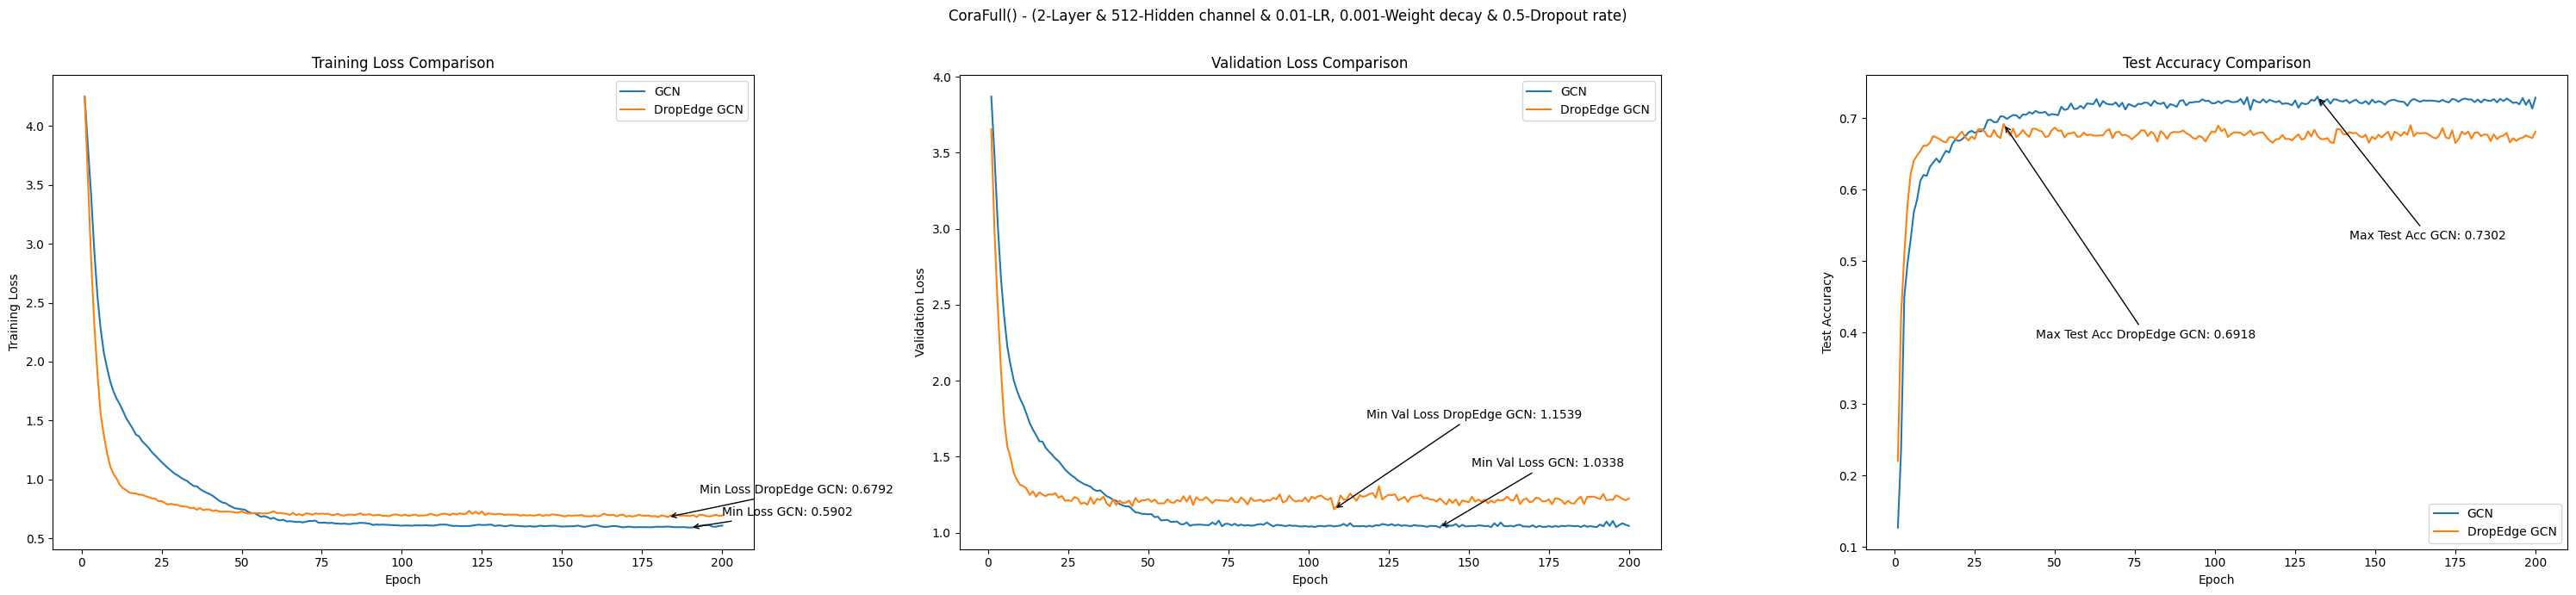


Test Accuracy of GCN: 0.7028289972215207
Test Accuracy of DropEdge: 0.6707590300580955


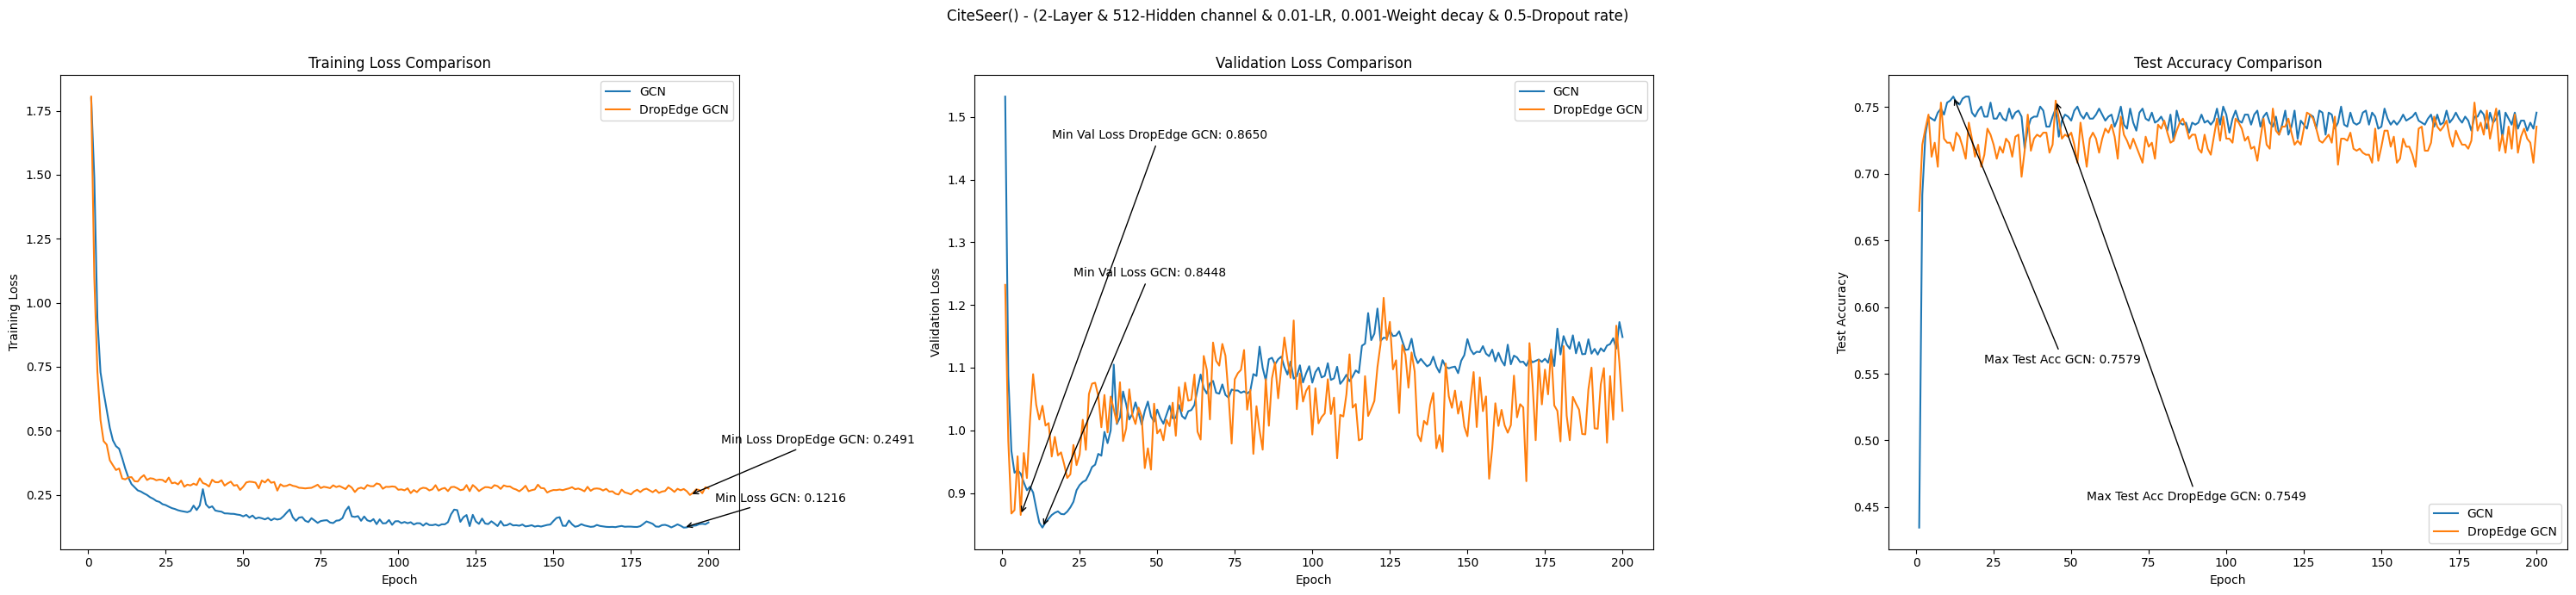


Test Accuracy of GCN: 0.7396616541353385
Test Accuracy of DropEdge: 0.7261052631578948


In [ ]:
# lrs = [0.01, 0.005]
num_layers = 2
# hidden_channel = 512
# weight_decays = [1e-5, 1e-3]
# dropout_rate = 0.8

for dataset, graph in datasets.items():
    criterion = nn.CrossEntropyLoss()
    out_channels = dataset.num_classes
    max_acc = 0
    max_info = []
    for lr in lrs:
      for weight_decay in weight_decays:
        for dropout_rate in dropout_rates:
          # GCN
          gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
          optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
          train_losses_gcn = []

          # DropEdge GCN
          dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                          dropout_rate=dropout_rate, num_layers=num_layers).to(device)
          optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
          train_losses_dropedge = []

          val_losses_gcn, val_losses_dropedge = [], []
          test_accs_gcn, test_accs_dropedge = [], []

          for epoch in range(n_epochs):
              loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
              loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))

              train_losses_gcn.append(loss_gcn)
              train_losses_dropedge.append(loss_dropedge)

              # Validation Loss
              val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
              val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
              val_losses_gcn.append(val_loss_gcn.item())
              val_losses_dropedge.append(val_loss_dropedge.item())

              # Test Accuracy
              test_acc_gcn = evaluate(gcn_model, graph.to(device))
              test_acc_dropedge = evaluate(dropedge_model, graph.to(device))
              test_accs_gcn.append(test_acc_gcn)
              test_accs_dropedge.append(test_acc_dropedge)

          if np.mean(test_acc_gcn) > max_acc:
              max_acc = np.mean(test_acc_gcn)
              max_info = [lr, weight_decay, hidden_channel, dropout_rate,
                          train_losses_gcn, train_losses_dropedge,
                          val_losses_gcn, val_losses_dropedge,
                          test_accs_gcn, test_accs_dropedge]

    plotBestLayers(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                                  max_info[4], max_info[5],
                                                  max_info[6], max_info[7],
                                                  max_info[8], max_info[9])

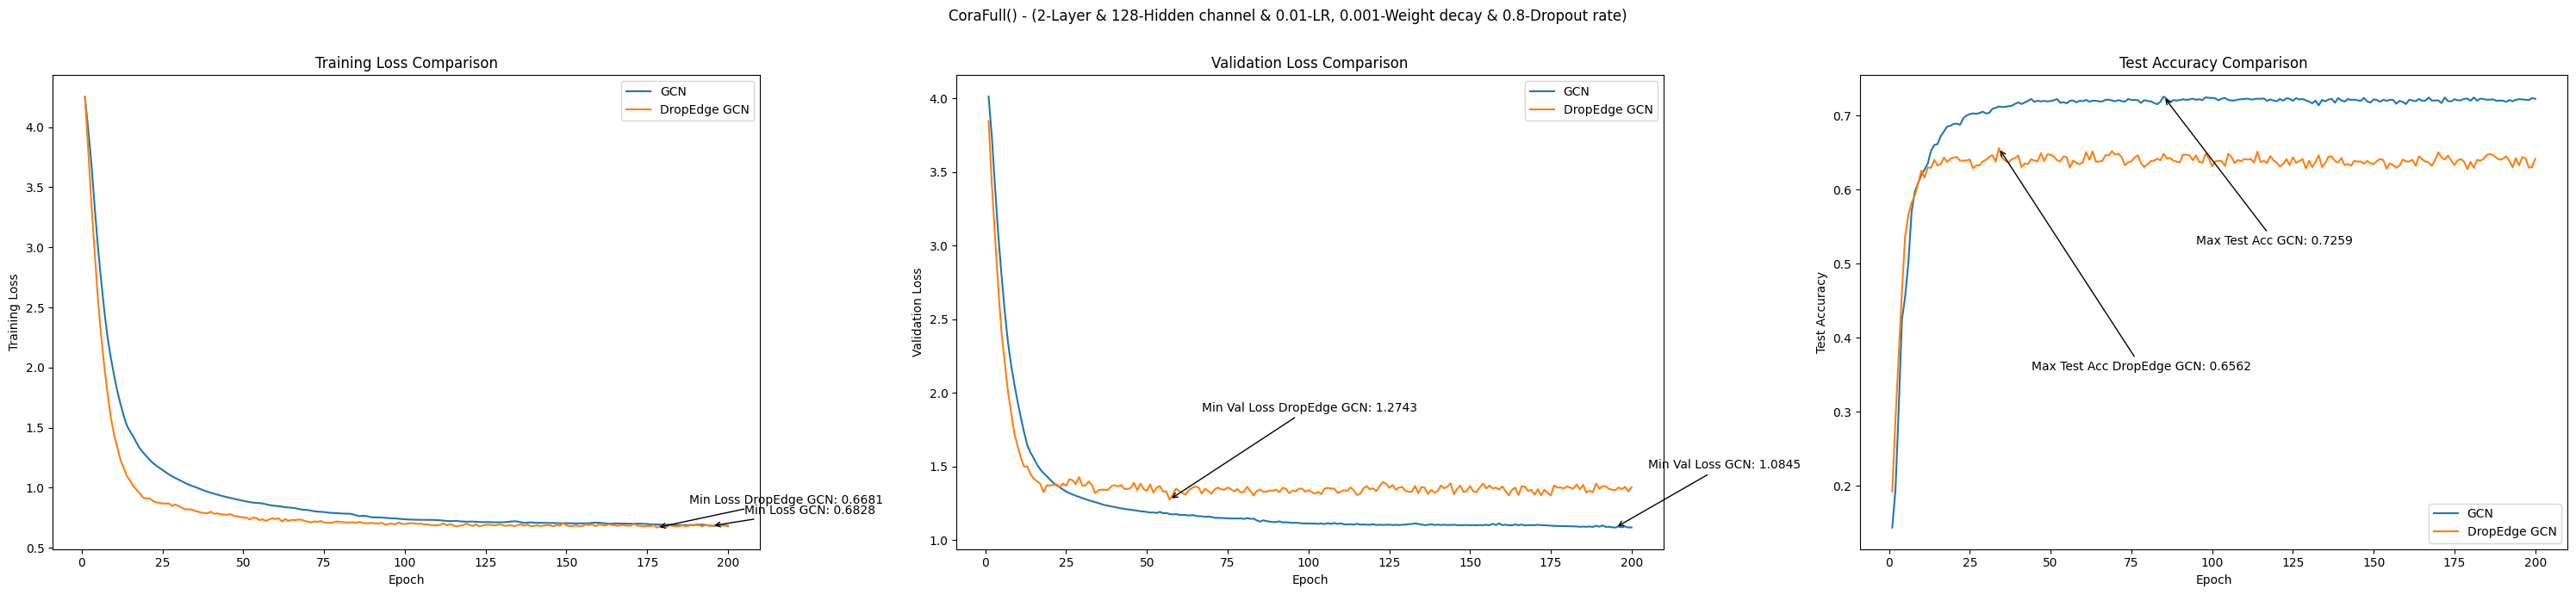


Test Accuracy of GCN: 0.7026913361960091
Test Accuracy of DropEdge: 0.6316986612781005


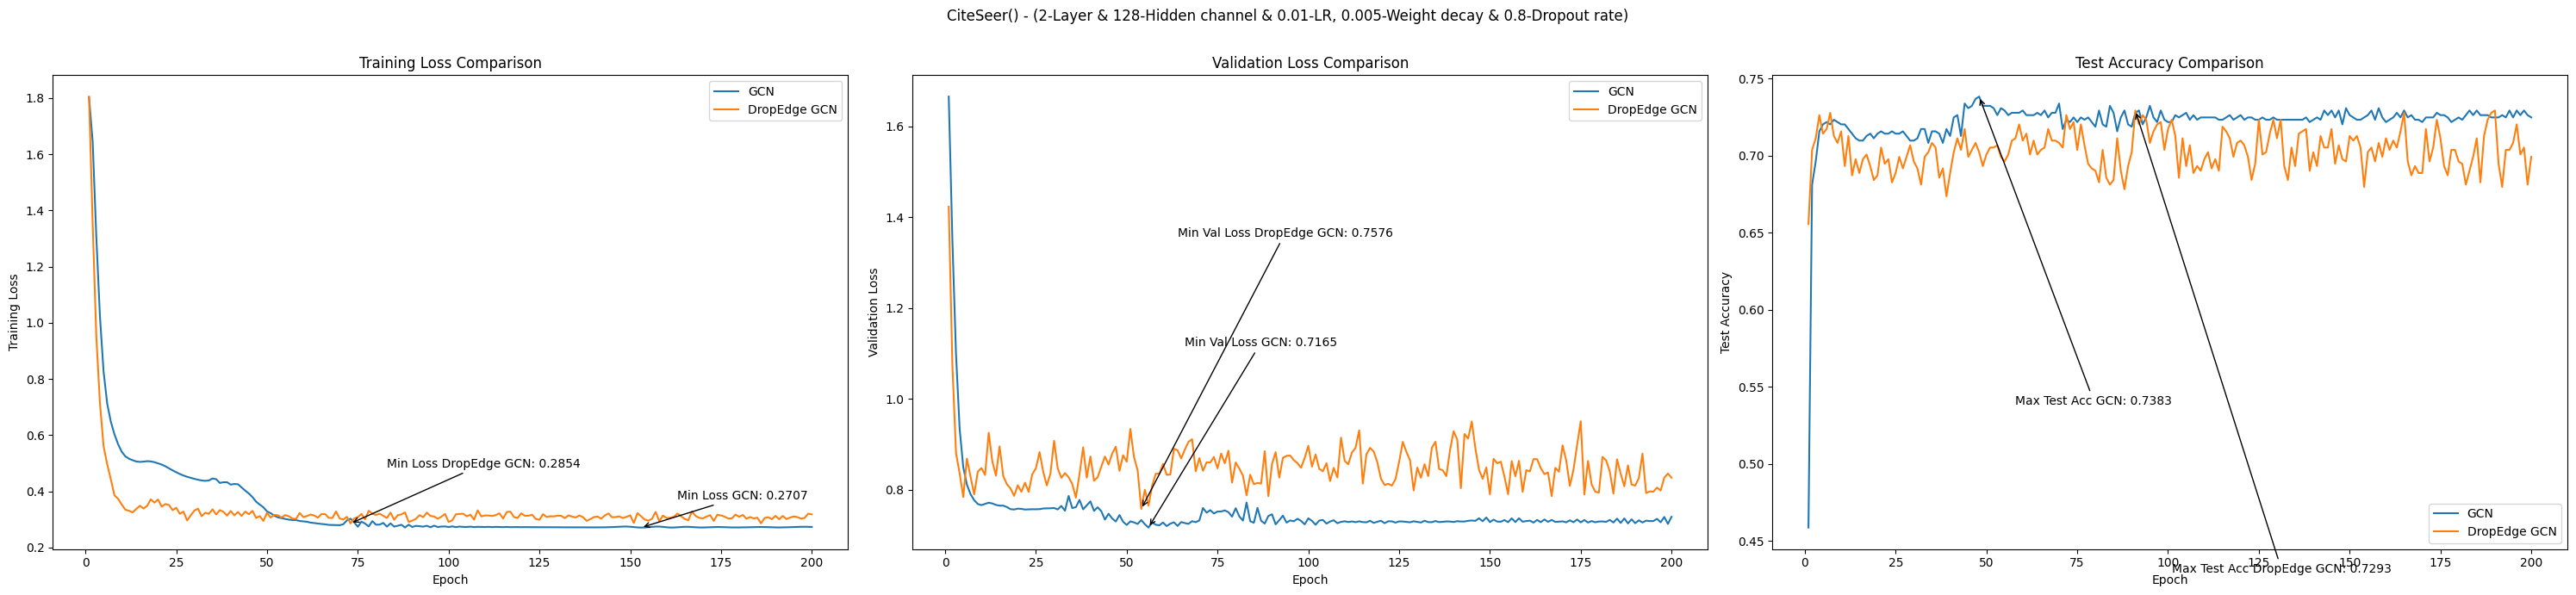


Test Accuracy of GCN: 0.7219323308270676
Test Accuracy of DropEdge: 0.7030676691729323


In [ ]:
lrs = [0.01, 0.005]
num_layers = 2
hidden_channel = 128
weight_decays = [5e-3, 1e-3]
dropout_rate = 0.8

for dataset, graph in datasets.items():
    criterion = nn.CrossEntropyLoss()
    out_channels = dataset.num_classes
    max_acc = 0
    max_info = []
    for lr in lrs:
      for weight_decay in weight_decays:
          # GCN
          gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
          optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
          train_losses_gcn = []

          # DropEdge GCN
          dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                          dropout_rate=dropout_rate, num_layers=num_layers).to(device)
          optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
          train_losses_dropedge = []

          val_losses_gcn, val_losses_dropedge = [], []
          test_accs_gcn, test_accs_dropedge = [], []

          for epoch in range(n_epochs):
              loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
              loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))

              train_losses_gcn.append(loss_gcn)
              train_losses_dropedge.append(loss_dropedge)

              # Validation Loss
              val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
              val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
              val_losses_gcn.append(val_loss_gcn.item())
              val_losses_dropedge.append(val_loss_dropedge.item())

              # Test Accuracy
              test_acc_gcn = evaluate(gcn_model, graph.to(device))
              test_acc_dropedge = evaluate(dropedge_model, graph.to(device))
              test_accs_gcn.append(test_acc_gcn)
              test_accs_dropedge.append(test_acc_dropedge)

          if np.mean(test_accs_dropedge) > max_acc:
              max_acc = np.mean(test_accs_gcn)
              max_info = [lr, weight_decay, hidden_channel, dropout_rate,
                          train_losses_gcn, train_losses_dropedge,
                          val_losses_gcn, val_losses_dropedge,
                          test_accs_gcn, test_accs_dropedge]

    plotBestLayers(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                                  max_info[4], max_info[5],
                                                  max_info[6], max_info[7],
                                                  max_info[8], max_info[9])

# Calculate with 4-layers

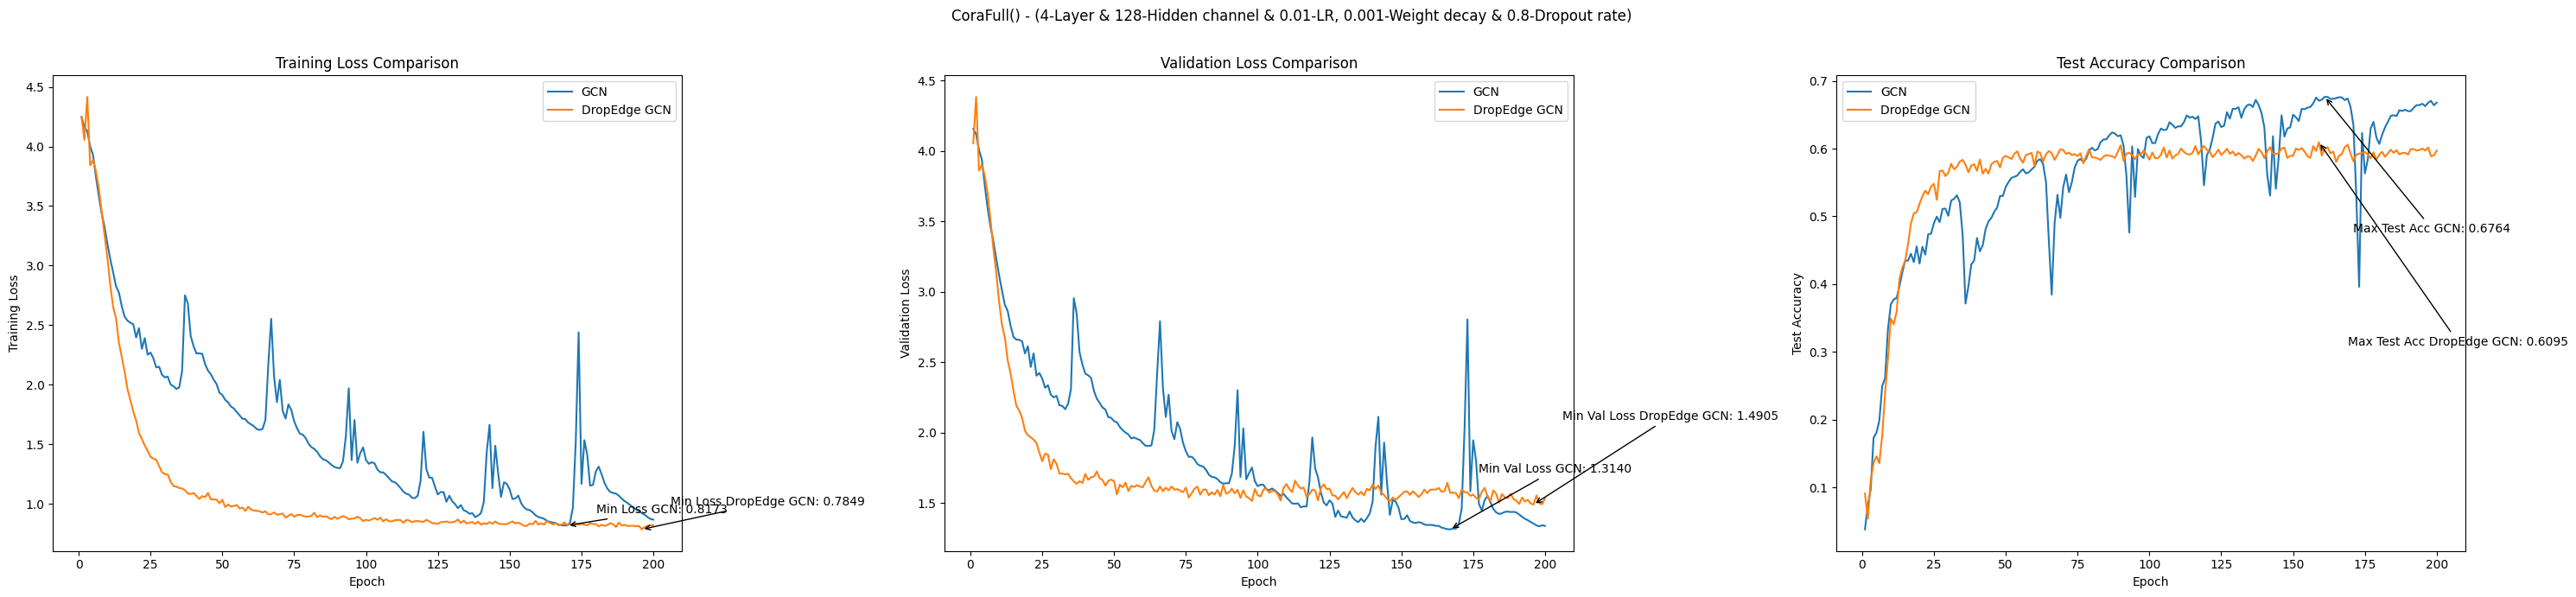


Test Accuracy of GCN: 0.564880020207123
Test Accuracy of DropEdge: 0.5602626925991412


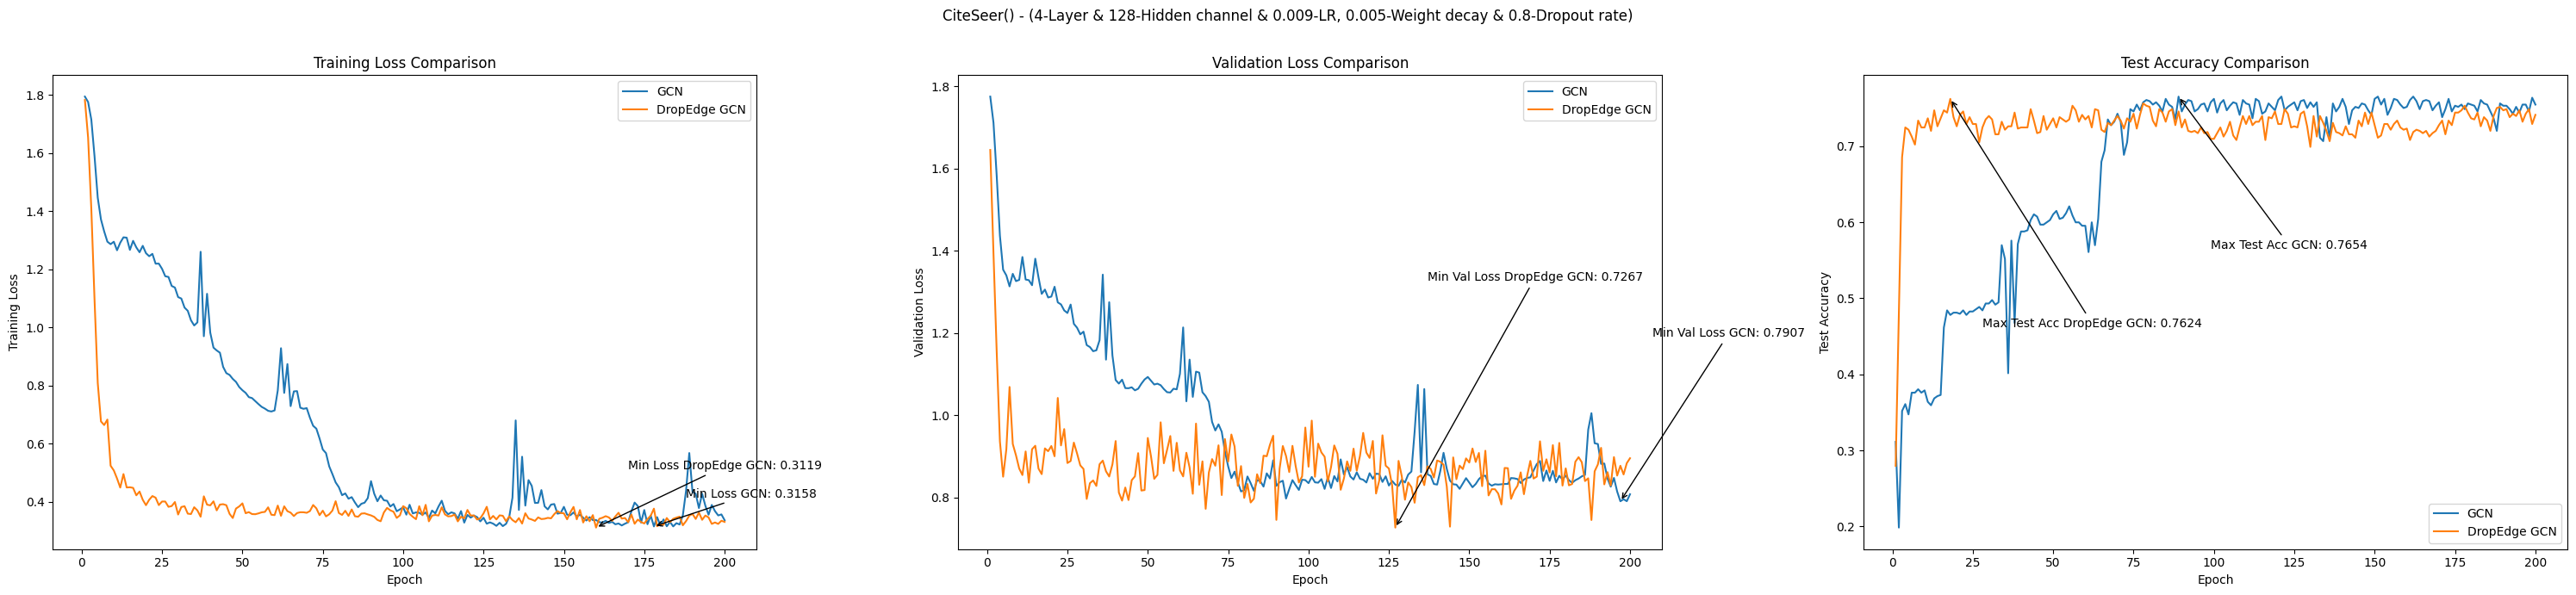


Test Accuracy of GCN: 0.6703458646616542
Test Accuracy of DropEdge: 0.7270676691729324


In [ ]:
lrs = [0.01, 0.009]
num_layers = 4
hidden_channel = 128
weight_decays = [5e-3, 1e-3]
dropout_rate = 0.8

for dataset, graph in datasets.items():
    criterion = nn.CrossEntropyLoss()
    out_channels = dataset.num_classes
    max_acc = 0
    max_info = []
    for lr in lrs:
      for weight_decay in weight_decays:
        # GCN
        gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
        optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
        train_losses_gcn = []

        # DropEdge GCN
        dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                        dropout_rate=dropout_rate, num_layers=num_layers).to(device)
        optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
        train_losses_dropedge = []

        val_losses_gcn, val_losses_dropedge = [], []
        test_accs_gcn, test_accs_dropedge = [], []

        for epoch in range(n_epochs):
            loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
            loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))

            train_losses_gcn.append(loss_gcn)
            train_losses_dropedge.append(loss_dropedge)

            # Validation Loss
            val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
            val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
            val_losses_gcn.append(val_loss_gcn.item())
            val_losses_dropedge.append(val_loss_dropedge.item())

            # Test Accuracy
            test_acc_gcn = evaluate(gcn_model, graph.to(device))
            test_acc_dropedge = evaluate(dropedge_model, graph.to(device))
            test_accs_gcn.append(test_acc_gcn)
            test_accs_dropedge.append(test_acc_dropedge)

        if np.mean(test_acc_gcn) > max_acc:
            max_acc = np.mean(test_acc_gcn)
            max_info = [lr, weight_decay, hidden_channel, dropout_rate,
                        train_losses_gcn, train_losses_dropedge,
                        val_losses_gcn, val_losses_dropedge,
                        test_accs_gcn, test_accs_dropedge]

    plotBestLayers(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                                  max_info[4], max_info[5],
                                                  max_info[6], max_info[7],
                                                  max_info[8], max_info[9])

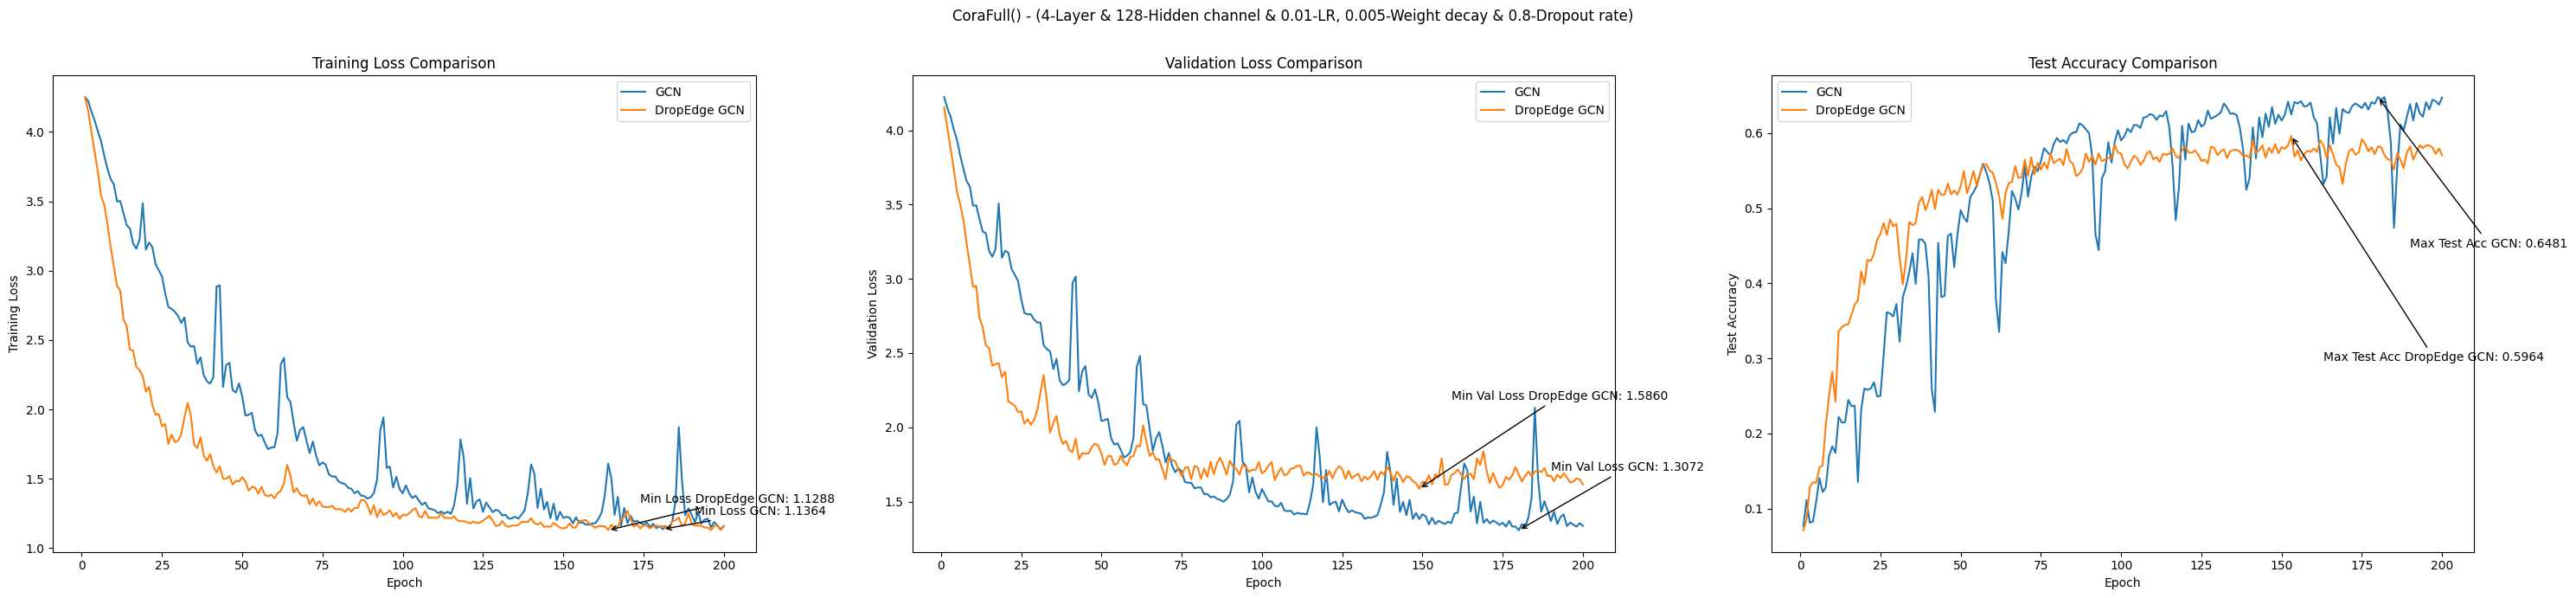


Test Accuracy of GCN: 0.5145087143217985
Test Accuracy of DropEdge: 0.5232306137913614


In [ ]:
lr = 0.01
num_layers = 4
hidden_channel = 128
weight_decay = 5e-3
dropout_rate = 0.8
dataset = dataset_CoraFull
graph = graph_CoraFull
criterion = nn.CrossEntropyLoss()
out_channels = dataset.num_classes
max_acc = 0
max_info = []

# GCN
gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_gcn = []

# DropEdge GCN
dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                dropout_rate=dropout_rate, num_layers=num_layers).to(device)
optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_dropedge = []

val_losses_gcn, val_losses_dropedge = [], []
test_accs_gcn, test_accs_dropedge = [], []

for epoch in range(n_epochs):
  loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
  loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))

  train_losses_gcn.append(loss_gcn)
  train_losses_dropedge.append(loss_dropedge)

  # Validation Loss
  val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_losses_gcn.append(val_loss_gcn.item())
  val_losses_dropedge.append(val_loss_dropedge.item())

  # Test Accuracy
  test_acc_gcn = evaluate(gcn_model, graph.to(device))
  test_acc_dropedge = evaluate(dropedge_model, graph.to(device))
  test_accs_gcn.append(test_acc_gcn)
  test_accs_dropedge.append(test_acc_dropedge)

max_acc = np.mean(test_accs_dropedge)
max_info = [lr, weight_decay, hidden_channel, dropout_rate,
            train_losses_gcn, train_losses_dropedge,
            val_losses_gcn, val_losses_dropedge,
            test_accs_gcn, test_accs_dropedge]

plotBestLayers(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                              max_info[4], max_info[5],
                                              max_info[6], max_info[7],
                                              max_info[8], max_info[9])

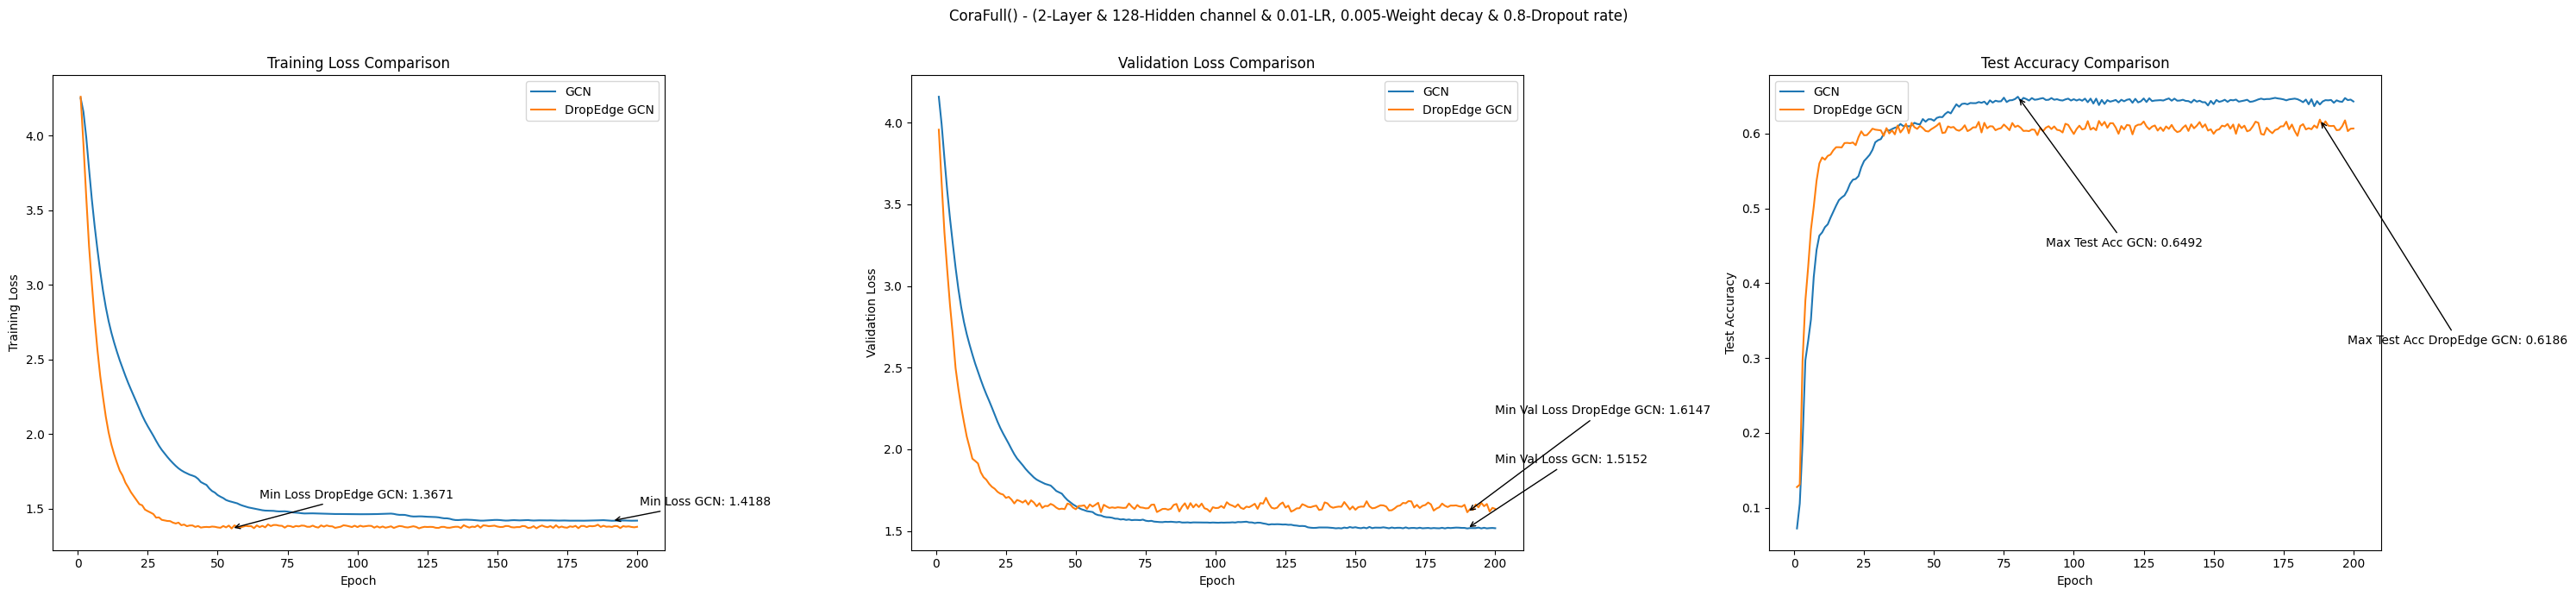


Test Accuracy of GCN: 0.6122972972972973
Test Accuracy of DropEdge: 0.5952134377368022


In [ ]:
lr = 0.01
num_layers = 2
hidden_channel = 128
weight_decay = 5e-3
dropout_rate = 0.8
dataset = dataset_CoraFull
graph = graph_CoraFull
criterion = nn.CrossEntropyLoss()
out_channels = dataset.num_classes
max_acc = 0
max_info = []

# GCN
gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_gcn = []

# DropEdge GCN
dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                dropout_rate=dropout_rate, num_layers=num_layers).to(device)
optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_dropedge = []

val_losses_gcn, val_losses_dropedge = [], []
test_accs_gcn, test_accs_dropedge = [], []

for epoch in range(n_epochs):
  loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
  loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))

  train_losses_gcn.append(loss_gcn)
  train_losses_dropedge.append(loss_dropedge)

  # Validation Loss
  val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_losses_gcn.append(val_loss_gcn.item())
  val_losses_dropedge.append(val_loss_dropedge.item())

  # Test Accuracy
  test_acc_gcn = evaluate(gcn_model, graph.to(device))
  test_acc_dropedge = evaluate(dropedge_model, graph.to(device))
  test_accs_gcn.append(test_acc_gcn)
  test_accs_dropedge.append(test_acc_dropedge)

max_acc = np.mean(test_accs_dropedge)
max_info = [lr, weight_decay, hidden_channel, dropout_rate,
            train_losses_gcn, train_losses_dropedge,
            val_losses_gcn, val_losses_dropedge,
            test_accs_gcn, test_accs_dropedge]

plotBestLayers(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                              max_info[4], max_info[5],
                                              max_info[6], max_info[7],
                                              max_info[8], max_info[9])

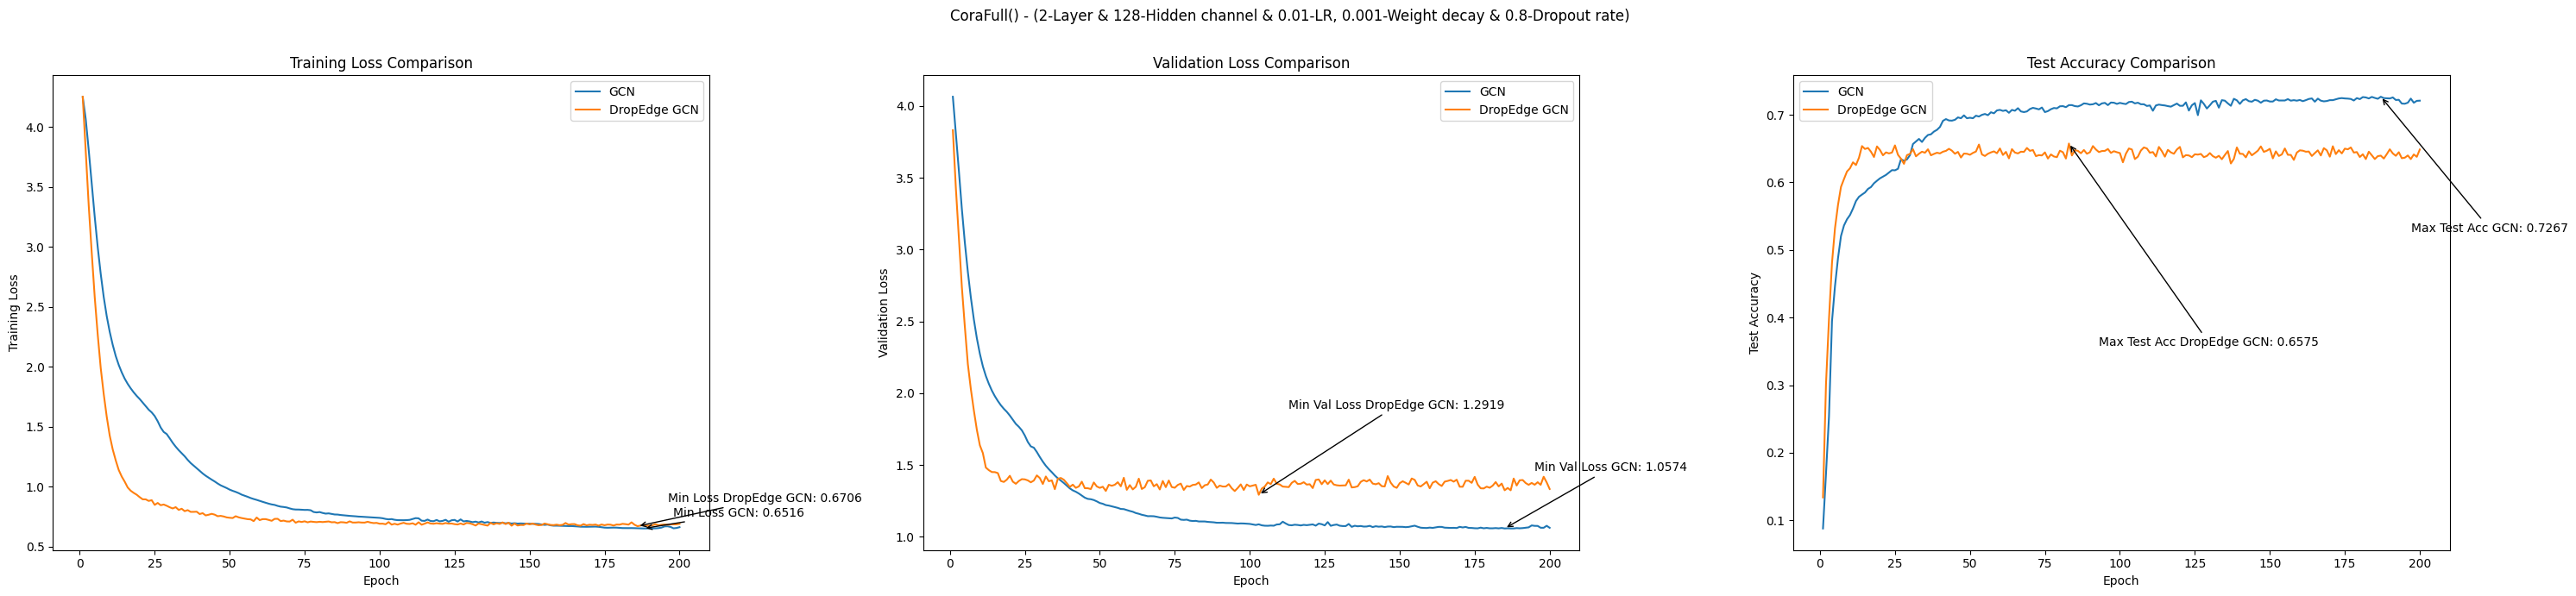


Test Accuracy of GCN: 0.6855910583480676
Test Accuracy of DropEdge: 0.6352424854761304


In [ ]:
lr = 0.01
num_layers = 2
hidden_channel = 128
weight_decay = 1e-3
dropout_rate = 0.8
dataset = dataset_CoraFull
graph = graph_CoraFull
criterion = nn.CrossEntropyLoss()
out_channels = dataset.num_classes
max_acc = 0
max_info = []

# GCN
gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_gcn = []

# DropEdge GCN
dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                dropout_rate=dropout_rate, num_layers=num_layers).to(device)
optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_dropedge = []

val_losses_gcn, val_losses_dropedge = [], []
test_accs_gcn, test_accs_dropedge = [], []

for epoch in range(n_epochs):
  loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
  loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))

  train_losses_gcn.append(loss_gcn)
  train_losses_dropedge.append(loss_dropedge)

  # Validation Loss
  val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_losses_gcn.append(val_loss_gcn.item())
  val_losses_dropedge.append(val_loss_dropedge.item())

  # Test Accuracy
  test_acc_gcn = evaluate(gcn_model, graph.to(device))
  test_acc_dropedge = evaluate(dropedge_model, graph.to(device))
  test_accs_gcn.append(test_acc_gcn)
  test_accs_dropedge.append(test_acc_dropedge)

max_acc = np.mean(test_accs_dropedge)
max_info = [lr, weight_decay, hidden_channel, dropout_rate,
            train_losses_gcn, train_losses_dropedge,
            val_losses_gcn, val_losses_dropedge,
            test_accs_gcn, test_accs_dropedge]

plotBestLayers(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                              max_info[4], max_info[5],
                                              max_info[6], max_info[7],
                                              max_info[8], max_info[9])

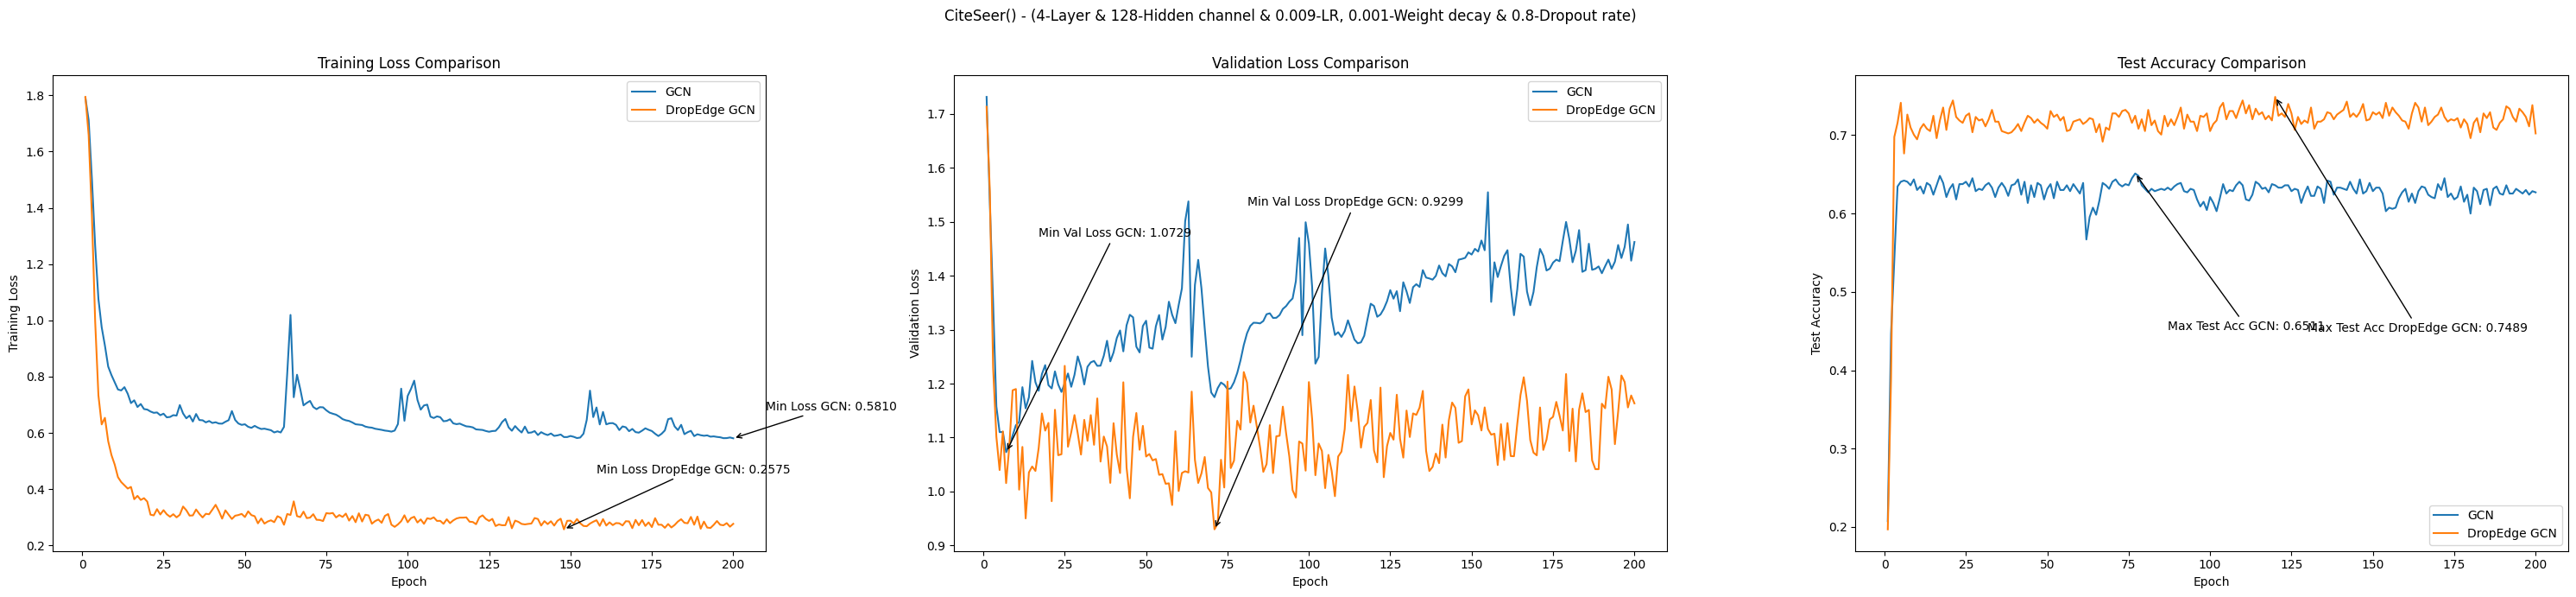


Test Accuracy of GCN: 0.625624060150376
Test Accuracy of DropEdge: 0.7161203007518796


In [ ]:
lr = 0.009
num_layers = 4
hidden_channel = 128
weight_decay = 1e-3
dropout_rate = 0.8
dataset = dataset_Cite
graph = graph_Cite
criterion = nn.CrossEntropyLoss()
out_channels = dataset.num_classes
max_acc = 0
max_info = []

# GCN
gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_gcn = []

# DropEdge GCN
dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                dropout_rate=dropout_rate, num_layers=num_layers).to(device)
optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_dropedge = []

val_losses_gcn, val_losses_dropedge = [], []
test_accs_gcn, test_accs_dropedge = [], []

for epoch in range(n_epochs):
  loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
  loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))

  train_losses_gcn.append(loss_gcn)
  train_losses_dropedge.append(loss_dropedge)

  # Validation Loss
  val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_losses_gcn.append(val_loss_gcn.item())
  val_losses_dropedge.append(val_loss_dropedge.item())

  # Test Accuracy
  test_acc_gcn = evaluate(gcn_model, graph.to(device))
  test_acc_dropedge = evaluate(dropedge_model, graph.to(device))
  test_accs_gcn.append(test_acc_gcn)
  test_accs_dropedge.append(test_acc_dropedge)

max_acc = np.mean(test_accs_dropedge)
max_info = [lr, weight_decay, hidden_channel, dropout_rate,
            train_losses_gcn, train_losses_dropedge,
            val_losses_gcn, val_losses_dropedge,
            test_accs_gcn, test_accs_dropedge]

plotBestLayers(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                              max_info[4], max_info[5],
                                              max_info[6], max_info[7],
                                              max_info[8], max_info[9])

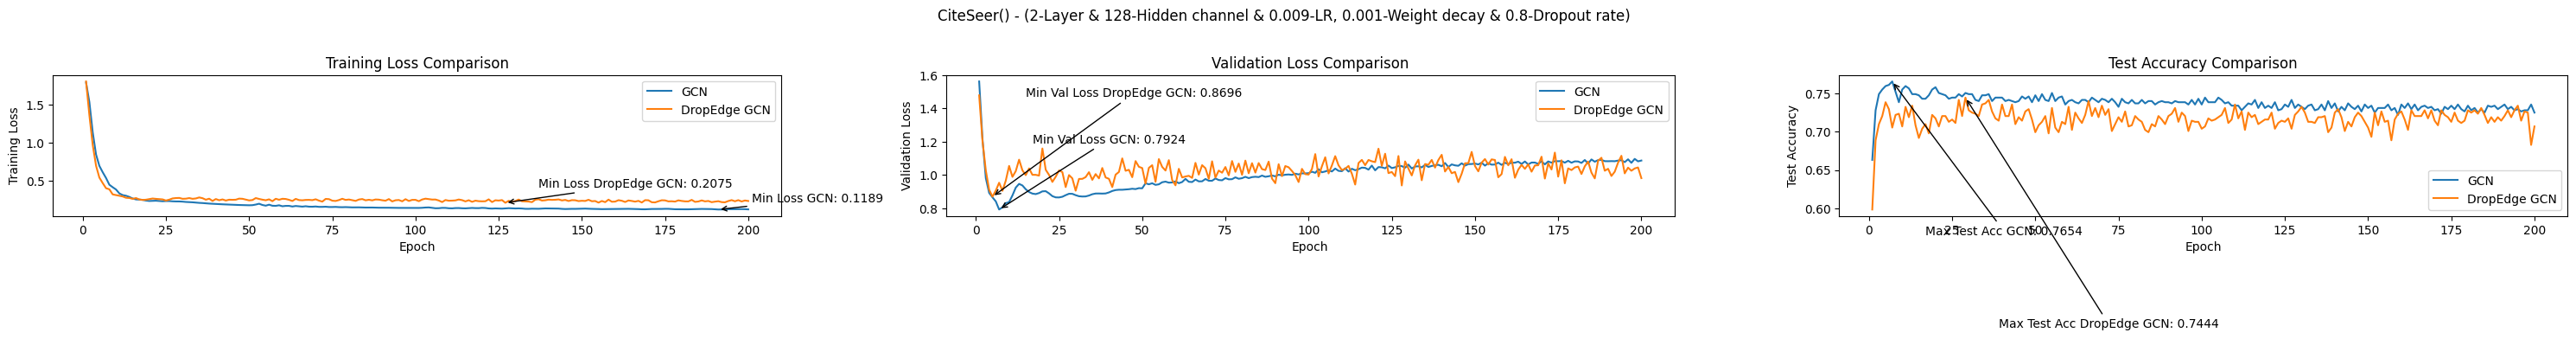


Test Accuracy of GCN: 0.7373759398496241
Test Accuracy of DropEdge: 0.716781954887218


In [ ]:
lr = 0.009
num_layers = 2
hidden_channel = 128
weight_decay = 1e-3
dropout_rate = 0.8
dataset = dataset_Cite
graph = graph_Cite
criterion = nn.CrossEntropyLoss()
out_channels = dataset.num_classes
max_acc = 0
max_info = []

# GCN
gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_gcn = []

# DropEdge GCN
dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                dropout_rate=dropout_rate, num_layers=num_layers).to(device)
optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_dropedge = []

val_losses_gcn, val_losses_dropedge = [], []
test_accs_gcn, test_accs_dropedge = [], []

for epoch in range(n_epochs):
  loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
  loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))

  train_losses_gcn.append(loss_gcn)
  train_losses_dropedge.append(loss_dropedge)

  # Validation Loss
  val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_losses_gcn.append(val_loss_gcn.item())
  val_losses_dropedge.append(val_loss_dropedge.item())

  # Test Accuracy
  test_acc_gcn = evaluate(gcn_model, graph.to(device))
  test_acc_dropedge = evaluate(dropedge_model, graph.to(device))
  test_accs_gcn.append(test_acc_gcn)
  test_accs_dropedge.append(test_acc_dropedge)

max_acc = np.mean(test_accs_dropedge)
max_info = [lr, weight_decay, hidden_channel, dropout_rate,
            train_losses_gcn, train_losses_dropedge,
            val_losses_gcn, val_losses_dropedge,
            test_accs_gcn, test_accs_dropedge]

plotBestLayers(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                              max_info[4], max_info[5],
                                              max_info[6], max_info[7],
                                              max_info[8], max_info[9])

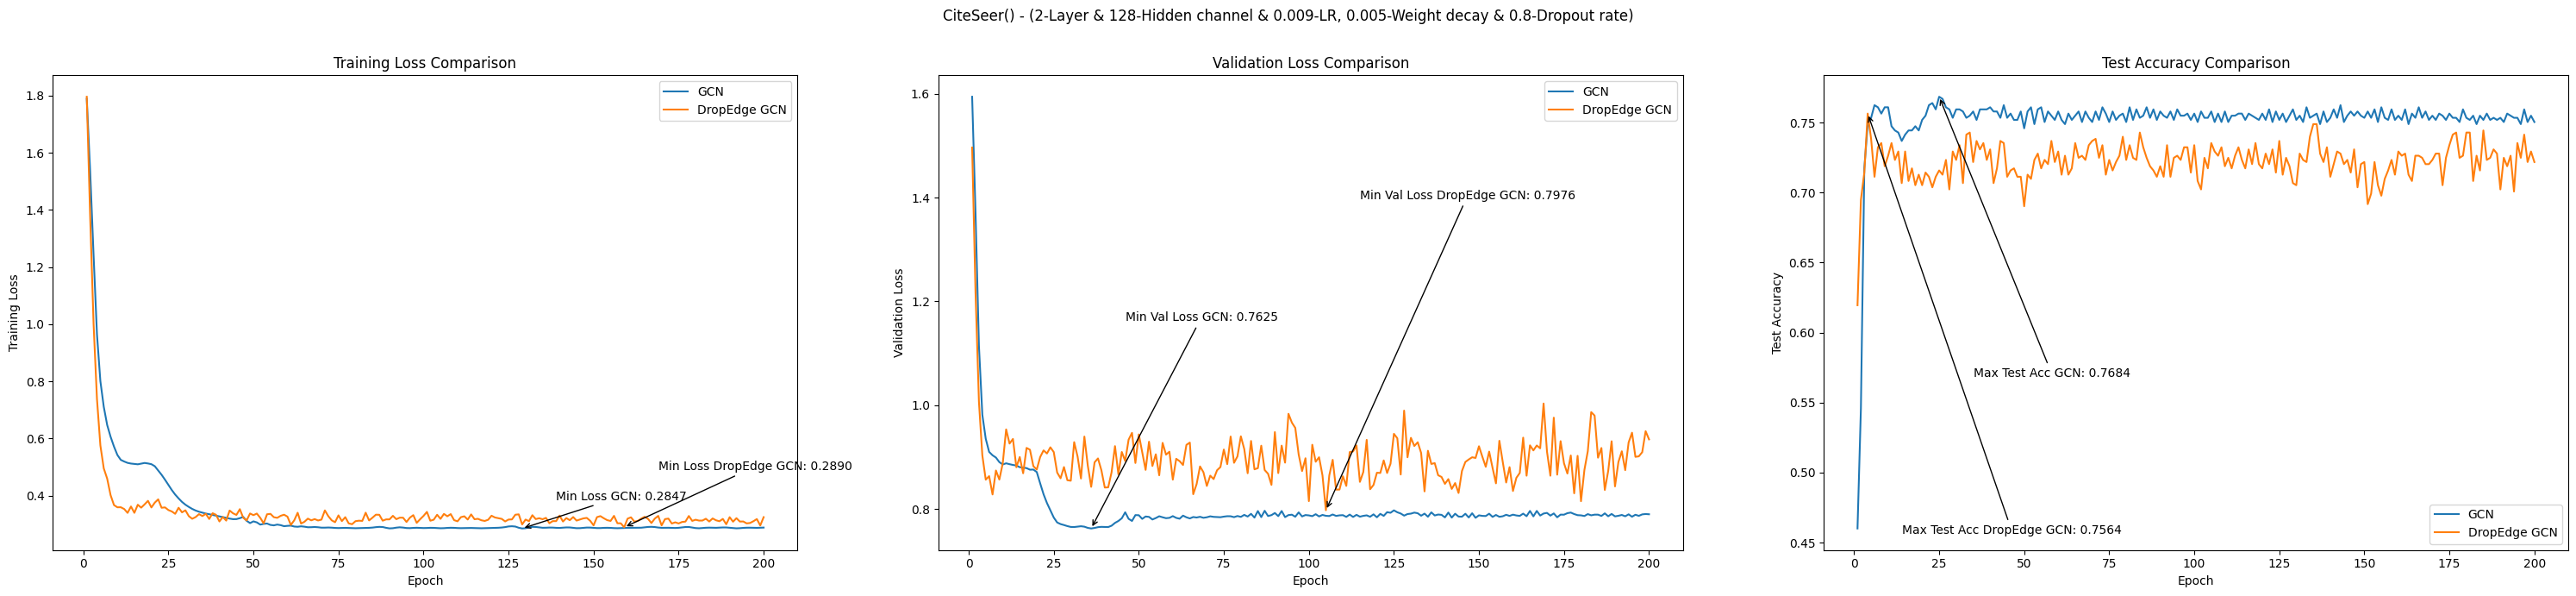


Test Accuracy of GCN: 0.7519999999999999
Test Accuracy of DropEdge: 0.722172932330827


In [ ]:
lr = 0.009
num_layers = 2
hidden_channel = 128
weight_decay = 5e-3
dropout_rate = 0.8
dataset = dataset_Cite
graph = graph_Cite
criterion = nn.CrossEntropyLoss()
out_channels = dataset.num_classes
max_acc = 0
max_info = []

# GCN
gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_gcn = []

# DropEdge GCN
dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                dropout_rate=dropout_rate, num_layers=num_layers).to(device)
optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_dropedge = []

val_losses_gcn, val_losses_dropedge = [], []
test_accs_gcn, test_accs_dropedge = [], []

for epoch in range(n_epochs):
  loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
  loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))

  train_losses_gcn.append(loss_gcn)
  train_losses_dropedge.append(loss_dropedge)

  # Validation Loss
  val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_losses_gcn.append(val_loss_gcn.item())
  val_losses_dropedge.append(val_loss_dropedge.item())

  # Test Accuracy
  test_acc_gcn = evaluate(gcn_model, graph.to(device))
  test_acc_dropedge = evaluate(dropedge_model, graph.to(device))
  test_accs_gcn.append(test_acc_gcn)
  test_accs_dropedge.append(test_acc_dropedge)

max_acc = np.mean(test_accs_dropedge)
max_info = [lr, weight_decay, hidden_channel, dropout_rate,
            train_losses_gcn, train_losses_dropedge,
            val_losses_gcn, val_losses_dropedge,
            test_accs_gcn, test_accs_dropedge]

plotBestLayers(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                              max_info[4], max_info[5],
                                              max_info[6], max_info[7],
                                              max_info[8], max_info[9])

# Compare with 8-layers

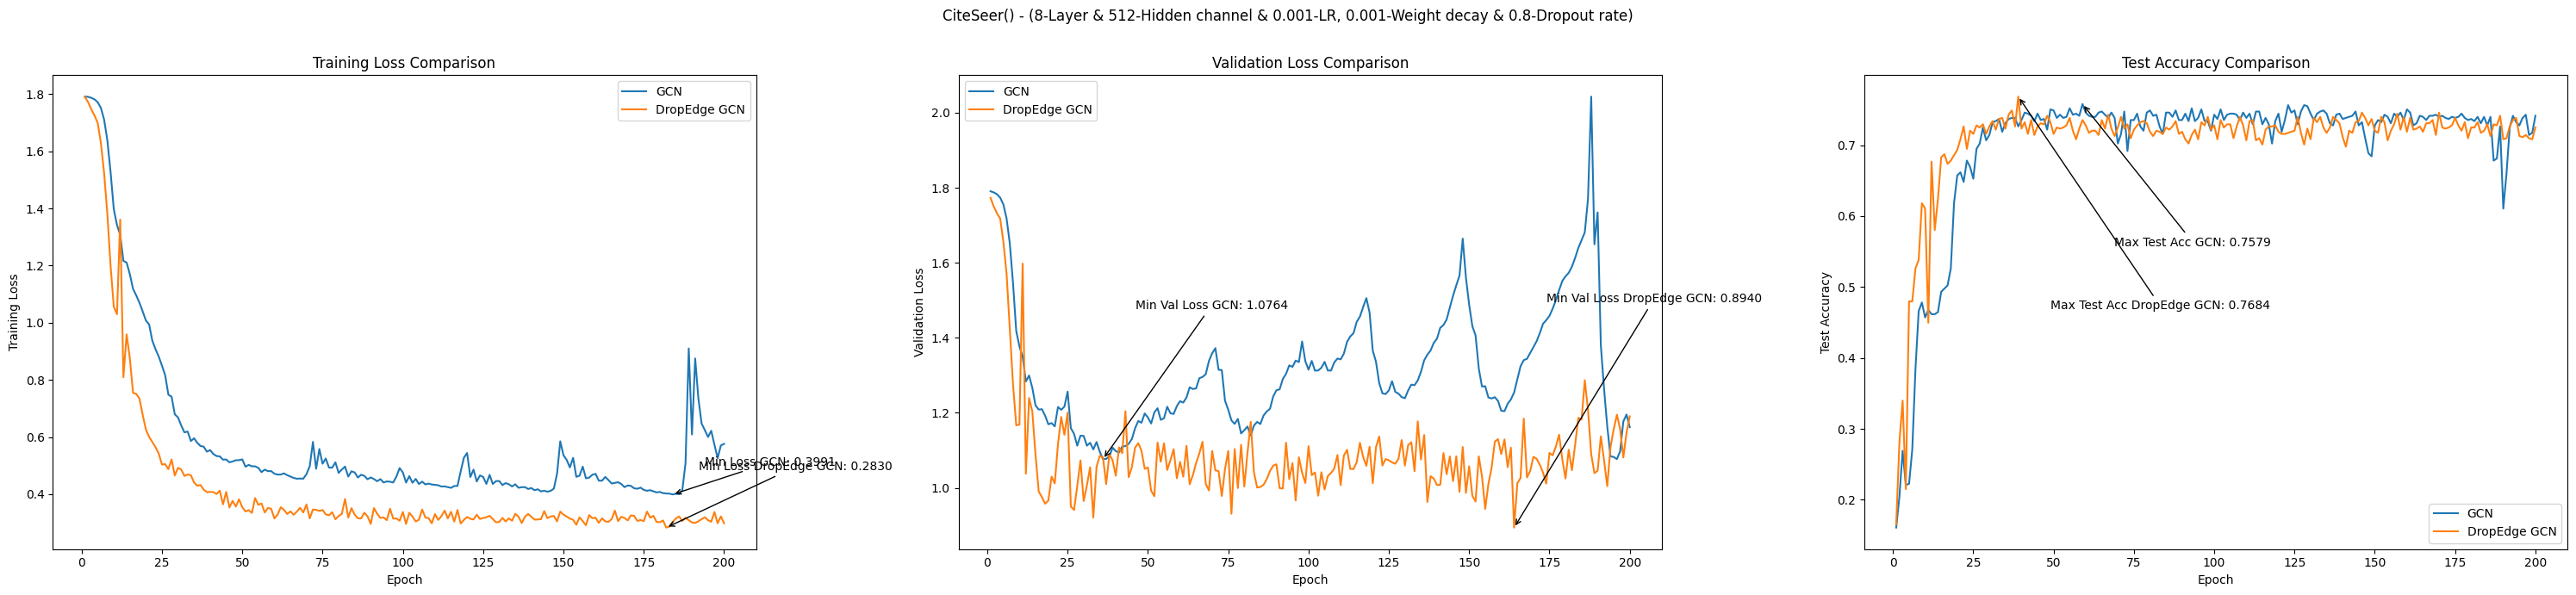


Test Accuracy of GCN: 0.7006466165413534
Test Accuracy of DropEdge: 0.705578947368421


In [ ]:
# lrs = [0.01, 0.005]
num_layers = 8
# hidden_channel = 512
# weight_decays = [1e-5, 1e-3]
# dropout_rate = 0.8
dataset = dataset_Cite
graph = graph_Cite
criterion = nn.CrossEntropyLoss()
out_channels = dataset.num_classes
max_acc = 0
max_info = []

for lr in lrs:
  for weight_decay in weight_decays:
    for dropout_rate in dropout_rates:
      # GCN
      gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
      optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
      train_losses_gcn = []

      # DropEdge GCN
      dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                      dropout_rate=dropout_rate, num_layers=num_layers).to(device)
      optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
      train_losses_dropedge = []

      val_losses_gcn, val_losses_dropedge = [], []
      test_accs_gcn, test_accs_dropedge = [], []

      for epoch in range(n_epochs):
        loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
        loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))

        train_losses_gcn.append(loss_gcn)
        train_losses_dropedge.append(loss_dropedge)

        # Validation Loss
        val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
        val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
        val_losses_gcn.append(val_loss_gcn.item())
        val_losses_dropedge.append(val_loss_dropedge.item())

        # Test Accuracy
        test_acc_gcn = evaluate(gcn_model, graph.to(device))
        test_acc_dropedge = evaluate(dropedge_model, graph.to(device))
        test_accs_gcn.append(test_acc_gcn)
        test_accs_dropedge.append(test_acc_dropedge)

      if np.mean(test_acc_gcn) > max_acc:
        max_acc = np.mean(test_acc_gcn)
        max_info = [lr, weight_decay, hidden_channel, dropout_rate,
                    train_losses_gcn, train_losses_dropedge,
                    val_losses_gcn, val_losses_dropedge,
                    test_accs_gcn, test_accs_dropedge]

plotBestLayers(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                              max_info[4], max_info[5],
                                              max_info[6], max_info[7],
                                              max_info[8], max_info[9])

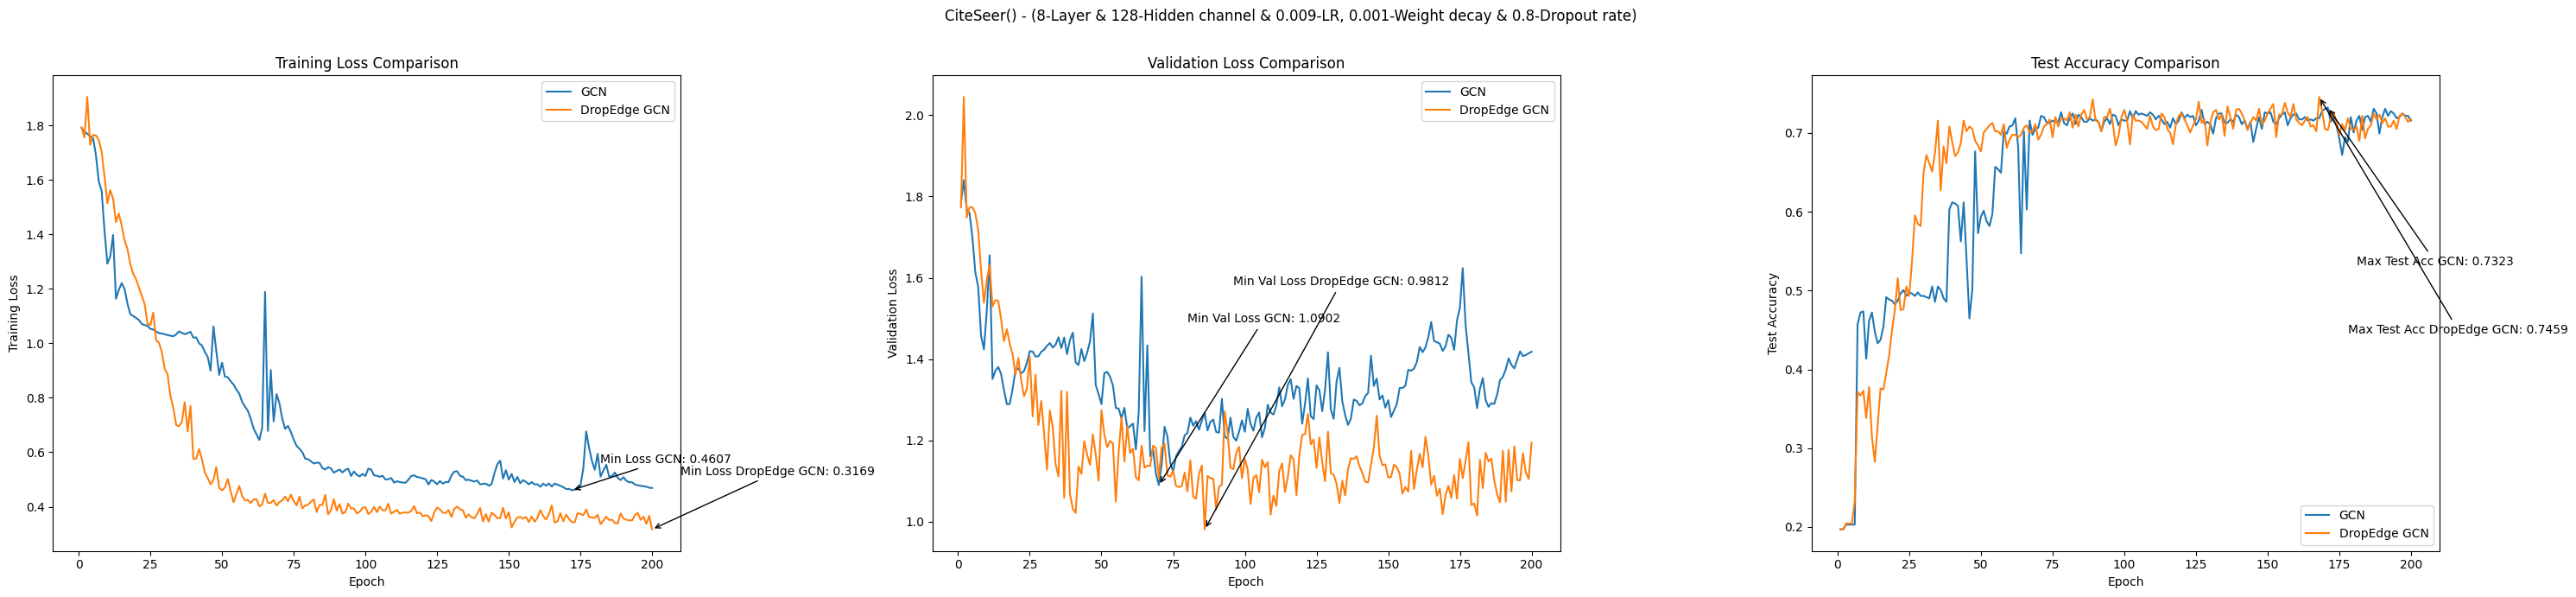


Test Accuracy of GCN: 0.6497894736842106
Test Accuracy of DropEdge: 0.6627067669172932


In [ ]:
lr = 0.009
num_layers = 8
hidden_channel = 128
weight_decay = 1e-3
dropout_rate = 0.8
dataset = dataset_Cite
graph = graph_Cite
criterion = nn.CrossEntropyLoss()
out_channels = dataset.num_classes
max_acc = 0
max_info = []

# GCN
gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_gcn = []

# DropEdge GCN
dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                dropout_rate=dropout_rate, num_layers=num_layers).to(device)
optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_dropedge = []

val_losses_gcn, val_losses_dropedge = [], []
test_accs_gcn, test_accs_dropedge = [], []

for epoch in range(n_epochs):
  loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
  loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))

  train_losses_gcn.append(loss_gcn)
  train_losses_dropedge.append(loss_dropedge)

  # Validation Loss
  val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_losses_gcn.append(val_loss_gcn.item())
  val_losses_dropedge.append(val_loss_dropedge.item())

  # Test Accuracy
  test_acc_gcn = evaluate(gcn_model, graph.to(device))
  test_acc_dropedge = evaluate(dropedge_model, graph.to(device))
  test_accs_gcn.append(test_acc_gcn)
  test_accs_dropedge.append(test_acc_dropedge)

max_acc = np.mean(test_accs_dropedge)
max_info = [lr, weight_decay, hidden_channel, dropout_rate,
            train_losses_gcn, train_losses_dropedge,
            val_losses_gcn, val_losses_dropedge,
            test_accs_gcn, test_accs_dropedge]

plotBestLayers(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                          max_info[4], max_info[5],
                                          max_info[6], max_info[7],
                                          max_info[8], max_info[9])

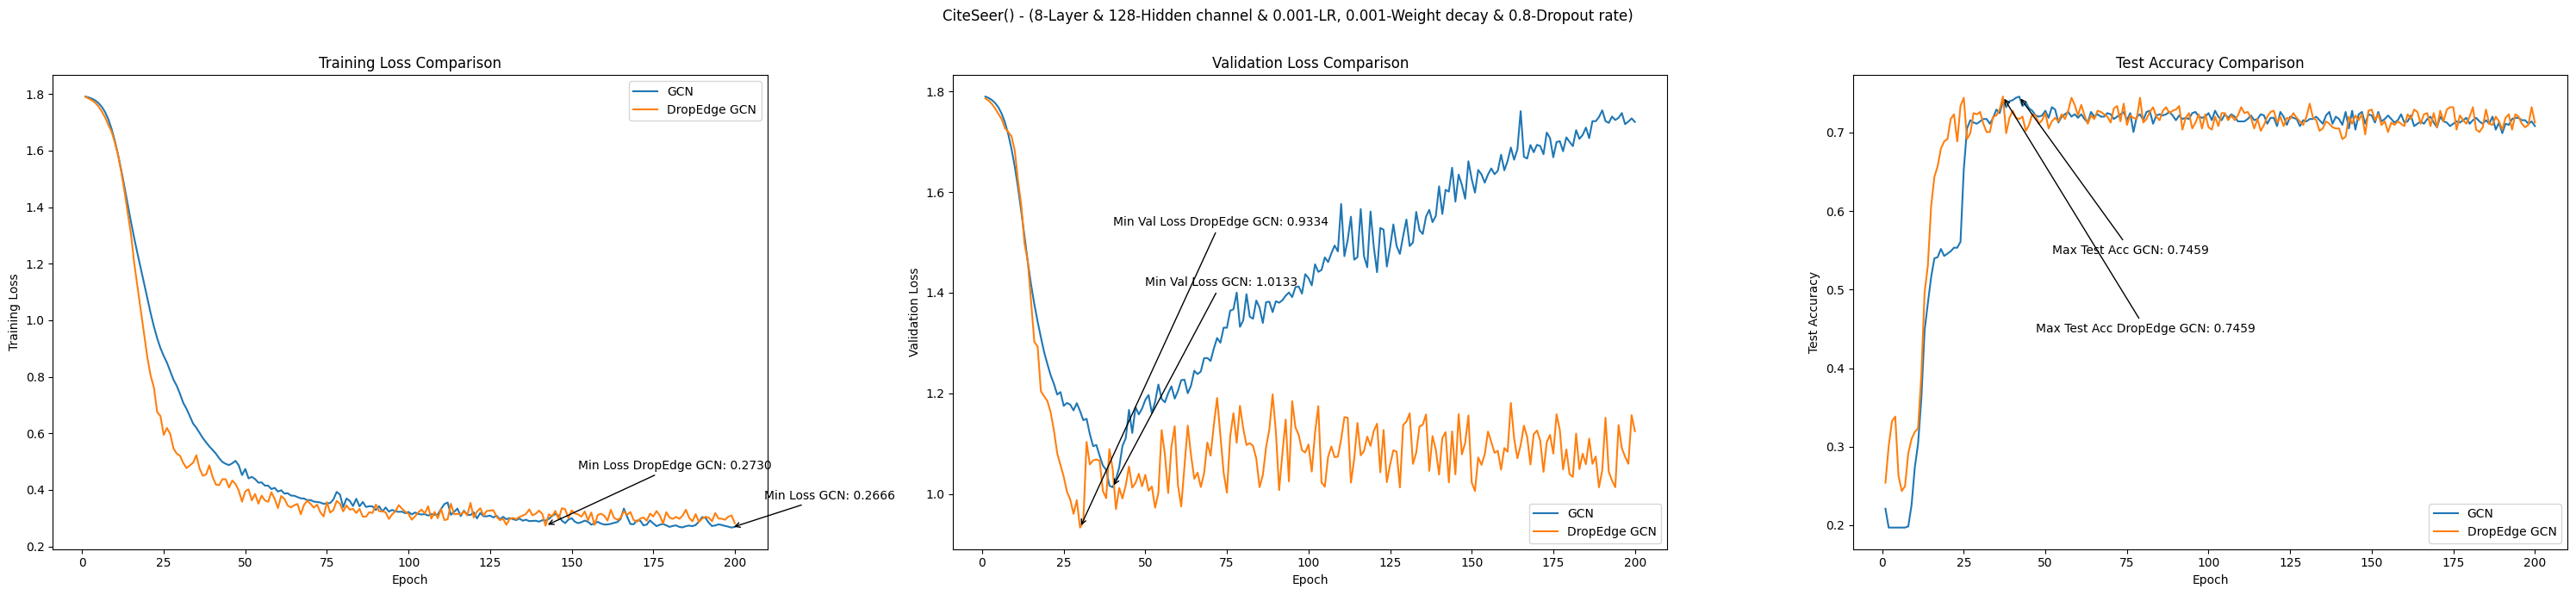


Test Accuracy of GCN: 0.6780601503759399
Test Accuracy of DropEdge: 0.6891353383458647


In [ ]:
lr = 0.001
num_layers = 8
hidden_channel = 128
weight_decay = 1e-3
dropout_rate = 0.8
dataset = dataset_Cite
graph = graph_Cite
criterion = nn.CrossEntropyLoss()
out_channels = dataset.num_classes
max_acc = 0
max_info = []

# GCN
gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_gcn = []

# DropEdge GCN
dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                dropout_rate=dropout_rate, num_layers=num_layers).to(device)
optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_dropedge = []

val_losses_gcn, val_losses_dropedge = [], []
test_accs_gcn, test_accs_dropedge = [], []

for epoch in range(n_epochs):
  loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
  loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))

  train_losses_gcn.append(loss_gcn)
  train_losses_dropedge.append(loss_dropedge)

  # Validation Loss
  val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_losses_gcn.append(val_loss_gcn.item())
  val_losses_dropedge.append(val_loss_dropedge.item())

  # Test Accuracy
  test_acc_gcn = evaluate(gcn_model, graph.to(device))
  test_acc_dropedge = evaluate(dropedge_model, graph.to(device))
  test_accs_gcn.append(test_acc_gcn)
  test_accs_dropedge.append(test_acc_dropedge)

max_acc = np.mean(test_accs_dropedge)
max_info = [lr, weight_decay, hidden_channel, dropout_rate,
            train_losses_gcn, train_losses_dropedge,
            val_losses_gcn, val_losses_dropedge,
            test_accs_gcn, test_accs_dropedge]

plotBestLayers(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                          max_info[4], max_info[5],
                                          max_info[6], max_info[7],
                                          max_info[8], max_info[9])

# SkipConnection

In [ ]:
class SkipConnectionGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super(SkipConnectionGCN, self).__init__()
        self.conv_layers = nn.ModuleList([GCNConv(in_channels, hidden_channels)])
        for _ in range(num_layers - 2):
            self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))
        self.conv_layers.append(GCNConv(hidden_channels, out_channels))
        self.skip_layers = nn.ModuleList([nn.Linear(in_channels, hidden_channels)] +
                                        [nn.Linear(hidden_channels, hidden_channels) for _ in range(num_layers - 2)] +
                                        [nn.Linear(hidden_channels, out_channels)])

    def forward(self, x, edge_index):
        skip_connections = [x]
        for i, conv in enumerate(self.conv_layers[:-1]):
            x = F.relu(conv(x, edge_index) + self.skip_layers[i](skip_connections[-1]))
            skip_connections.append(x)
        x = self.conv_layers[-1](x, edge_index)
        return x

# Compare

<ipython-input-17-e30f7b50ca7b>:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


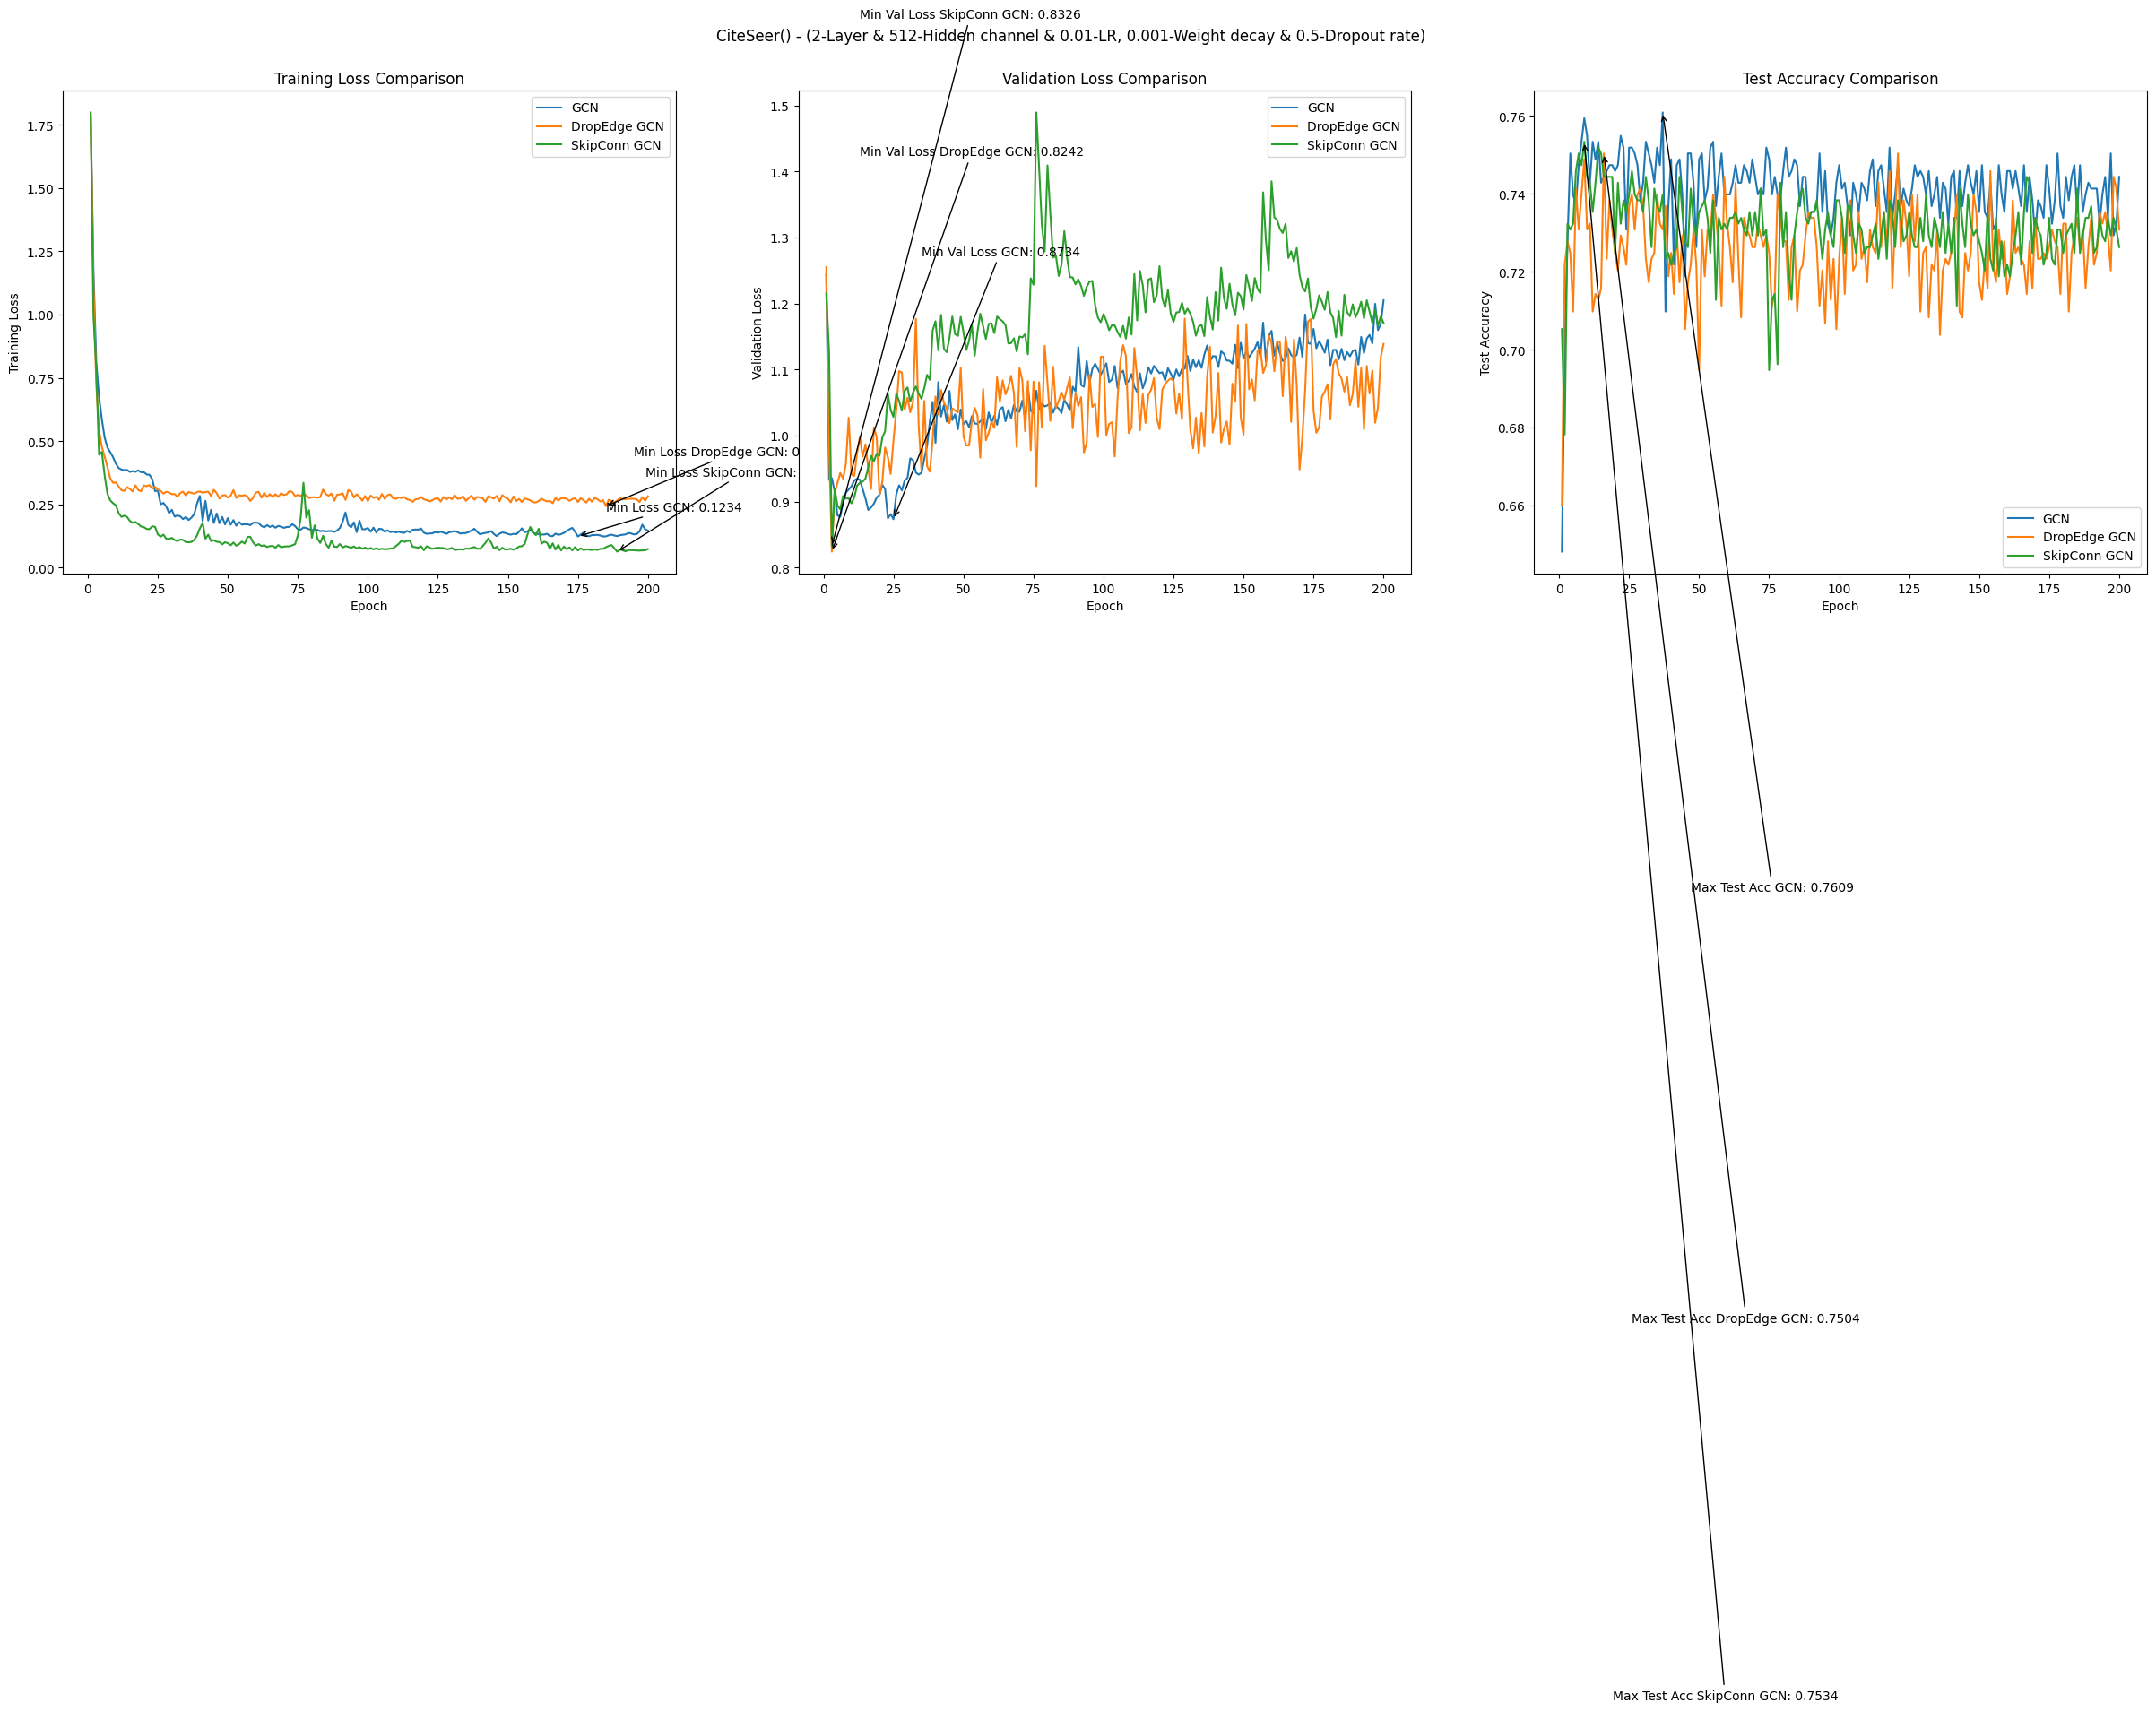


Test Accuracy of GCN: 0.7415037593984962
Test Accuracy of DropEdge: 0.7258947368421054
Test Accuracy of SkipConnection: 0.7312481203007519


In [ ]:
# lrs = [0.01, 0.005]
# num_layers = 8
# hidden_channel = 512
# weight_decays = [1e-5, 1e-3]
# dropout_rate = 0.8
dataset = dataset_Cite
graph = graph_Cite
criterion = nn.CrossEntropyLoss()
out_channels = dataset.num_classes

for num_layers in num_layers_list:
  max_acc = 0
  max_info = []
  for lr in lrs:
    for weight_decay in weight_decays:
      for dropout_rate in dropout_rates:
        # GCN
        gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
        optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
        train_losses_gcn = []

        # DropEdge GCN
        dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                      dropout_rate=dropout_rate, num_layers=num_layers).to(device)
        optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
        train_losses_dropedge = []

        # SkipConnection GCN
        skipconn_model = SkipConnectionGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                            num_layers=num_layers).to(device)
        optimizer_skipconn = optim.Adam(skipconn_model.parameters(), lr=lr, weight_decay=weight_decay)
        train_losses_skipconn = []

        val_losses_gcn, val_losses_dropedge, val_losses_skipconn = [], [], []
        test_accs_gcn, test_accs_dropedge, test_accs_skipconn = [], [], []

        for epoch in range(n_epochs):
          loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
          loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))
          loss_skipconn = train(skipconn_model, optimizer_skipconn, graph.to(device))

          train_losses_gcn.append(loss_gcn)
          train_losses_dropedge.append(loss_dropedge)
          train_losses_skipconn.append(loss_skipconn)

          # Validation Loss
          val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
          val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
          val_loss_skipconn = criterion(skipconn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
          val_losses_gcn.append(val_loss_gcn.item())
          val_losses_dropedge.append(val_loss_dropedge.item())
          val_losses_skipconn.append(val_loss_skipconn.item())

          # Test Accuracy
          test_acc_gcn = evaluate(gcn_model, graph)
          test_acc_dropedge = evaluate(dropedge_model, graph)
          test_acc_skipconn = evaluate(skipconn_model, graph)
          test_accs_gcn.append(test_acc_gcn)
          test_accs_dropedge.append(test_acc_dropedge)
          test_accs_skipconn.append(test_acc_skipconn)

        if np.mean(test_acc_gcn) > max_acc:
          max_acc = np.mean(test_acc_gcn)
          max_info = [lr, weight_decay, hidden_channel, dropout_rate,
                      train_losses_gcn, train_losses_dropedge, train_losses_skipconn,
                      val_losses_gcn, val_losses_dropedge, val_losses_skipconn,
                      test_accs_gcn, test_accs_dropedge, test_accs_skipconn]

  plotBestLayers2(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                            max_info[4], max_info[5], max_info[6],
                                            max_info[7], max_info[8], max_info[9],
                                            max_info[10], max_info[11], max_info[12])

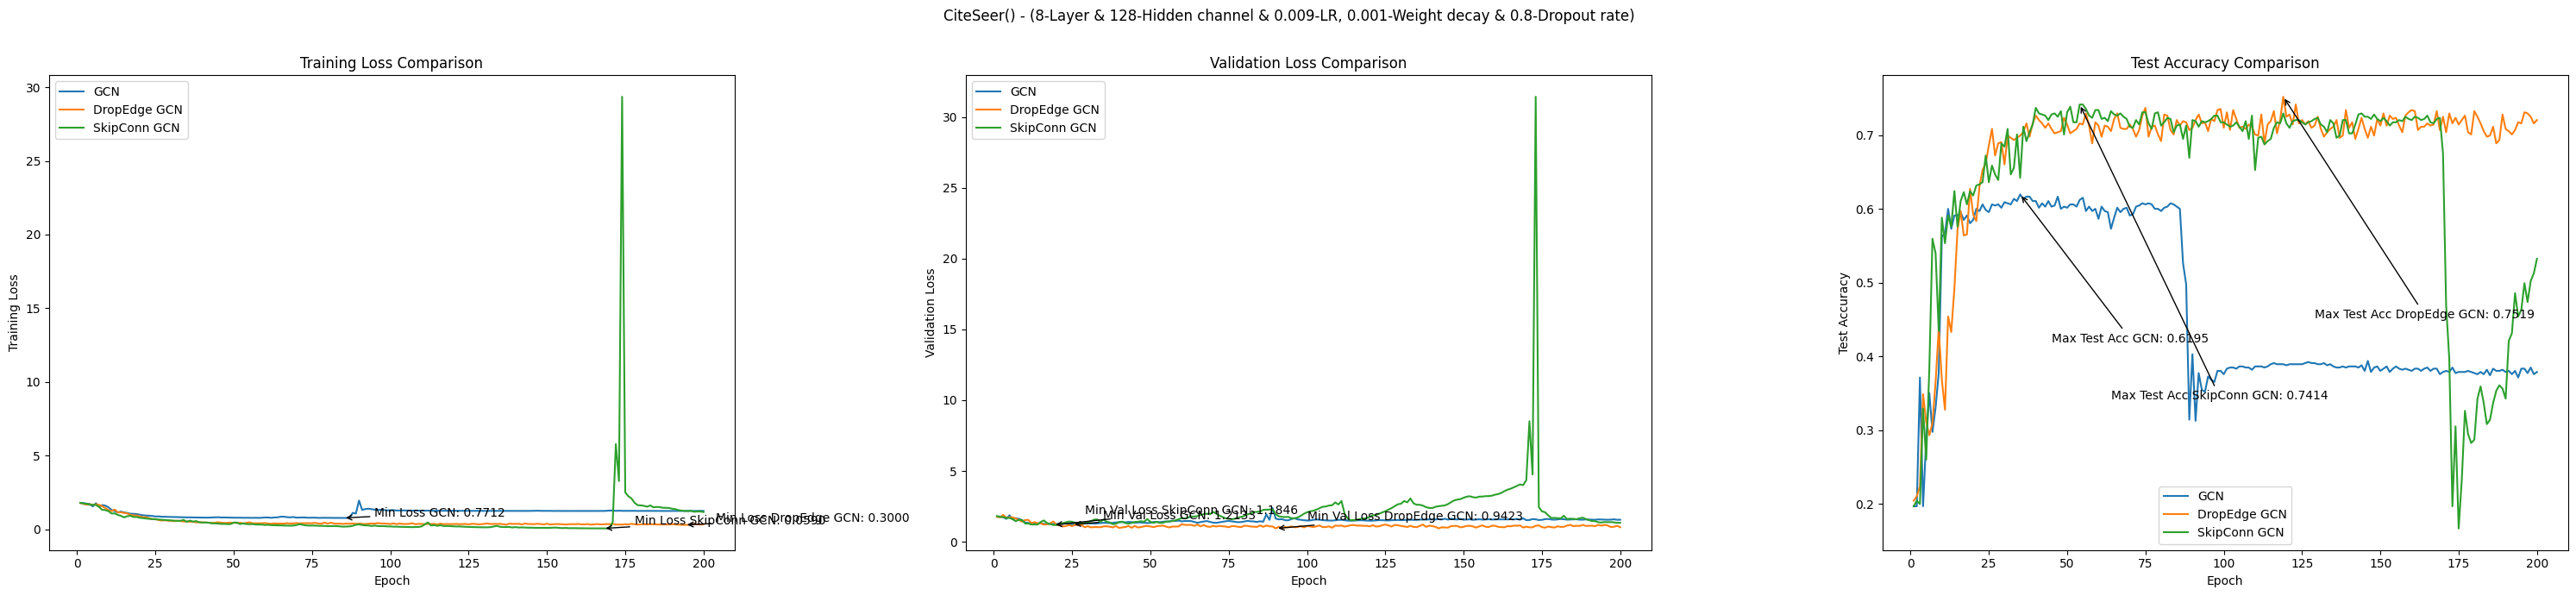


Test Accuracy of GCN: 0.4630451127819549
Test Accuracy of DropEdge: 0.6813609022556392
Test Accuracy of SkipConnection: 0.6377518796992482


In [ ]:
lr = 0.009
num_layers = 8
hidden_channel = 128
weight_decay = 1e-3
dropout_rate = 0.8
dataset = dataset_Cite
graph = graph_Cite
criterion = nn.CrossEntropyLoss()
out_channels = dataset.num_classes

max_acc = 0
max_info = []
# GCN
gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels, num_layers=num_layers).to(device)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_gcn = []

# DropEdge GCN
dropedge_model = DropEdgeGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                              dropout_rate=dropout_rate, num_layers=num_layers).to(device)
optimizer_dropedge = optim.Adam(dropedge_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_dropedge = []

# SkipConnection GCN
skipconn_model = SkipConnectionGCN(in_channels=dataset.num_features, hidden_channels=hidden_channel, out_channels=out_channels,
                                    num_layers=num_layers).to(device)
optimizer_skipconn = optim.Adam(skipconn_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses_skipconn = []

val_losses_gcn, val_losses_dropedge, val_losses_skipconn = [], [], []
test_accs_gcn, test_accs_dropedge, test_accs_skipconn = [], [], []

for epoch in range(n_epochs):
  loss_gcn = train(gcn_model, optimizer_gcn, graph.to(device))
  loss_dropedge = train(dropedge_model, optimizer_dropedge, graph.to(device))
  loss_skipconn = train(skipconn_model, optimizer_skipconn, graph.to(device))

  train_losses_gcn.append(loss_gcn)
  train_losses_dropedge.append(loss_dropedge)
  train_losses_skipconn.append(loss_skipconn)

  # Validation Loss
  val_loss_gcn = criterion(gcn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_loss_dropedge = criterion(dropedge_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_loss_skipconn = criterion(skipconn_model(graph.x.to(device), graph.edge_index.to(device))[graph.val_mask], graph.y[graph.val_mask])
  val_losses_gcn.append(val_loss_gcn.item())
  val_losses_dropedge.append(val_loss_dropedge.item())
  val_losses_skipconn.append(val_loss_skipconn.item())

  # Test Accuracy
  test_acc_gcn = evaluate(gcn_model, graph)
  test_acc_dropedge = evaluate(dropedge_model, graph)
  test_acc_skipconn = evaluate(skipconn_model, graph)
  test_accs_gcn.append(test_acc_gcn)
  test_accs_dropedge.append(test_acc_dropedge)
  test_accs_skipconn.append(test_acc_skipconn)

max_acc = np.mean(test_accs_dropedge)
max_info = [lr, weight_decay, hidden_channel, dropout_rate,
            train_losses_gcn, train_losses_dropedge, train_losses_skipconn,
            val_losses_gcn, val_losses_dropedge, val_losses_skipconn,
            test_accs_gcn, test_accs_dropedge, test_accs_skipconn]

plotBestLayers2(dataset, n_epochs, num_layers, max_info[0], max_info[1], max_info[2], max_info[3],
                                      max_info[4], max_info[5], max_info[6],
                                      max_info[7], max_info[8], max_info[9],
                                      max_info[10], max_info[11], max_info[12])